# Выявление причин убыточности рекламных кампаний развлекательного приложения

На основании данных о пользователях, привлеченных с 1 мая по 27 октября 2019 года:

* **файл visits_info.csv** - лог сервера с информацией о посещениях сайта:

* **User Id** — уникальный идентификатор пользователя,
* **Region** — страна пользователя,
* **Device** — тип устройства пользователя,
* **Channel** — идентификатор источника перехода,
* **Session Start** — дата и время начала сессии,
* **Session End** — дата и время окончания сессии.


* **файл orders_info.csv** — информация о покупках:

* **User Id** — уникальный идентификатор пользователя,
* **Event Dt** — дата и время покупки,
* **Revenue** — сумма заказа.


* **файл costs.csv** — информация о расходах на рекламу

* **Channel** — идентификатор рекламного источника,
* **Dt** — дата проведения рекламной кампании,
* **Costs** — расходы на эту кампанию.

Провести **АНАЛИЗ** 
* как клиенты пользуются приложением
* когда начинают покупать
* сколько денег приносит каждый клиент
* когда расходы на привлечение клиента окупаются
* какие факторы мешают привлечению клиентов

Сделать **ВЫВОД**

> о причинах неэффективности привлечения пользователей

Предложить **РЕКОМЕНДАЦИИ**

> как повысить эффективность инвестиций в маркетинг

## Загрузка и подготовка данных к анализу
Путь к файлам:

 -   /datasets/visits_info.csv
 -   /datasets/orders_info.csv
 -   /datasets/costs_info.csv

In [1]:
# импортируем библиотеки, подготавливаем рабочую среду

import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
pd.set_option('display.max_columns', None)

In [2]:
# загружаем данные о визитах, заказах, расходах,
# выводим информацию о данных,
# выводим произвольные 5 строк из таблиц

visits = pd.read_csv('/datasets/visits_info.csv')
orders = pd.read_csv('/datasets/orders_info.csv')
costs = pd.read_csv('/datasets/costs_info.csv')

display(visits.info(), visits.sample(5))
print()        
display(orders.info(), orders.sample(5))
print()
display(costs.info(), costs.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
User Id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null object
Session End      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

User Id         Region   Device       Channel     Session Start  \
171955  715947763696  United States  Android       organic  03.10.2019 14:18   
168528  164090394895  United States   iPhone        TipTop  01.10.2019 14:29   
4043    911018300111  United States   iPhone       YRabbit  06.05.2019 20:23   
50658   334113956476  United States   iPhone  MediaTornado  23.06.2019 09:41   
66539   880705062837  United States   iPhone        TipTop  06.07.2019 20:54   

             Session End  
171955  03.10.2019 14:50  
168528  01.10.2019 15:06  
4043    06.05.2019 20:28  
50658   23.06.2019 09:50  
66539   06.07.2019 22:11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
User Id     40212 non-null int64
Event Dt    40212 non-null object
Revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

User Id             Event Dt  Revenue
28657   81338641246  2019-05-27 20:53:10     4.99
14482  633695306168  2019-08-26 21:55:46     4.99
39313  225395375073  2019-10-23 10:32:14     4.99
34244  129701778478  2019-08-29 09:08:24     4.99
29897  848511134767  2019-06-24 06:02:41     4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
Channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

dt         Channel  costs
617   2019-07-17          TipTop  187.2
1257  2019-10-25         LeapBob   14.7
1762  2019-09-20  lambdaMediaAds    9.6
154   2019-10-02        FaceBoom  259.6
1707  2019-07-27  lambdaMediaAds    6.4

In [3]:
# приводим записи к нижнему регистру

visits.columns = map(str.lower, visits.columns)
orders.columns = map(str.lower, orders.columns)
costs.columns = map(str.lower, costs.columns)

visits['region'] = visits['region'].str.lower()
visits['device'] = visits['device'].str.lower()
visits['channel'] = visits['channel'].str.lower()
costs['channel'] = costs['channel'].str.lower()

display(visits.head(2), orders.head(2), costs.head(2))

user id         region  device  channel     session start  \
0  981449118918  united states  iphone  organic  01.05.2019 02:36   
1  278965908054  united states  iphone  organic  01.05.2019 04:46   

        session end  
0  01.05.2019 02:45  
1  01.05.2019 04:47

user id             event dt  revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99

dt   channel  costs
0  2019-05-01  faceboom  113.3
1  2019-05-02  faceboom   78.1

In [4]:
# заменяем в названиях колонок пробелы на нижнее подчеркивание

visits.columns = visits.columns.str.replace(" ", "_")
orders.columns = orders.columns.str.replace(" ", "_")

print(visits.columns, orders.columns)


Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object') Index(['user_id', 'event_dt', 'revenue'], dtype='object')


In [5]:
# проверяем дубликаты

print('Кол-во дубликатов в таблице visits:', visits.duplicated().sum())
print()
print('Кол-во дубликатов в таблице orders:', orders.duplicated().sum())
print()
print('Кол-во дубликатов в таблице costs:', costs.duplicated().sum())

Кол-во дубликатов в таблице visits: 0

Кол-во дубликатов в таблице orders: 0

Кол-во дубликатов в таблице costs: 0


In [6]:
# приводим значения дата-время к типу datetime

visits['session_start'] = pd.to_datetime(visits['session_start'], format='%d.%m.%Y %H:%M')
visits['session_end'] = pd.to_datetime(visits['session_end'], format='%d.%m.%Y %H:%M')  
orders['event_dt'] = pd.to_datetime(orders['event_dt'], format='%Y-%m-%d %H:%M:%S')
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

display(visits.dtypes, orders.dtypes, costs.dtypes)

user_id                   int64
region                   object
device                   object
channel                  object
session_start    datetime64[ns]
session_end      datetime64[ns]
dtype: object

user_id              int64
event_dt    datetime64[ns]
revenue            float64
dtype: object

dt          object
channel     object
costs      float64
dtype: object

## Исследовательский анализ данных

* построение профили пользователей
* определение минимальной и максимальной даты привлечения пользователей
* изучение географии - из каких стран приходят посетители, какие страны дают больше всего платящих пользователей
* изучение устройств входа - какими устройствами они пользуются, с каких устройств чаще всего заходят платящие пользователи
* изучение каналов продвижения - по каким рекламным каналам шло привлечение пользователей, какие каналы приносят больше всего платящих пользователей

In [7]:
#создаем функцию для построения профилей
def get_profiles(visits, orders):
 # сортируем сессии по ID пользователя и дате привлечения
 # группируем по ID и находим параметры первых посещений
    profiles = (
     visits.sort_values(by=['user_id', 'session_start'])
     .groupby('user_id')
     .agg(
     {
     'session_start': 'min',
     'session_end': 'max',
     'channel': 'first',
     'device': 'first',
     'region': 'first',
     }
     )
# время первого посещения называем first_ts
     .rename(columns={'session_start': 'first_ts'})
# время последнего посещения называем last_ts
     .rename(columns={'session_end': 'last_ts'})
# возвращаем user_id из индекса     
     .reset_index() 
 )
# добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
# добавляем колонки "payer_yes", "payer_no"
    profiles['payer_yes'] = (profiles['payer'] == True).astype(int)
    profiles['payer_no'] = (profiles['payer'] == False).astype(int)
    # возвращаем профили
    return profiles 

In [8]:
# строим профили
profiles = get_profiles(visits, orders)
display(profiles.sample(5))
profiles.info()
print()

user_id            first_ts             last_ts  \
71102   471866398559 2019-08-24 05:05:00 2019-08-24 05:28:00   
58740   389835088392 2019-10-27 19:08:00 2019-10-27 19:18:00   
26490   176456142177 2019-05-23 10:49:00 2019-05-23 11:30:00   
122113  814116721944 2019-05-26 03:44:00 2019-05-26 03:47:00   
120282  801784297598 2019-05-04 18:40:00 2019-05-04 19:04:00   

                   channel   device         region  payer  payer_yes  payer_no  
71102   opplecreativemedia       pc             uk  False          0         1  
58740   opplecreativemedia       pc             uk  False          0         1  
26490       rocketsuperads   iphone  united states  False          0         1  
122113             organic  android  united states  False          0         1  
120282      rocketsuperads   iphone  united states  False          0         1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150008 entries, 0 to 150007
Data columns (total 9 columns):
user_id      150008 non-null int64
first_ts     150008 non-null datetime64[ns]
last_ts      150008 non-null datetime64[ns]
channel      150008 non-null object
device       150008 non-null object
region       150008 non-null object
payer        150008 non-null bool
payer_yes    150008 non-null int64
payer_no     150008 non-null int64
dtypes: bool(1), datetime64[ns](2), int64(3), object(3)
memory usage: 9.3+ MB



In [9]:
# проверяем кол-во пользователей,
# проверяем кол-во платящих и неплатящих пользователей
print('Всего пользователей:', profiles['user_id'].count())
print()
print('Из них кол-во платящих пользователей:',
      profiles['payer_yes'].sum(),
      (profiles['payer_yes'].sum() / profiles['user_id'].count() *100).round()
     )
print()
print('Из них кол-во не платящих пользователей:', profiles['payer_no'].sum())

Всего пользователей: 150008

Из них кол-во платящих пользователей: 8881 6.0

Из них кол-во не платящих пользователей: 141127


In [10]:
# определяем мин, макс дату привлечения пользователей 

print('Мин, макс даты привлечения по странам:')
display(profiles.groupby('region')['first_ts'].agg({'first_ts':['min', 'max']}))

print('Мин, макс даты привлечения по устройствам:')
display(profiles.groupby('device')['first_ts'].agg({'first_ts':['min', 'max']}))

print('Мин, макс даты привлечения по каналам привлечения:')
display(profiles.groupby('channel')['first_ts'].agg({'first_ts':['min', 'max']}))

Мин, макс даты привлечения по странам:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  after removing the cwd from sys.path.


first_ts                    
                              min                 max
region                                               
france        2019-05-01 00:05:00 2019-10-27 23:53:00
germany       2019-05-01 00:02:00 2019-10-27 23:56:00
uk            2019-05-01 00:01:00 2019-10-27 23:55:00
united states 2019-05-01 00:00:00 2019-10-27 23:59:00

Мин, макс даты привлечения по устройствам:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  import sys


first_ts                    
                        min                 max
device                                         
android 2019-05-01 00:02:00 2019-10-27 23:55:00
iphone  2019-05-01 00:06:00 2019-10-27 23:59:00
mac     2019-05-01 00:00:00 2019-10-27 23:43:00
pc      2019-05-01 00:01:00 2019-10-27 23:56:00

Мин, макс даты привлечения по каналам привлечения:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  # Remove the CWD from sys.path while we load stuff.


first_ts                    
                                   min                 max
channel                                                   
adnonsense         2019-05-01 00:01:00 2019-10-27 23:55:00
faceboom           2019-05-01 00:06:00 2019-10-27 23:54:00
lambdamediaads     2019-05-01 01:32:00 2019-10-27 22:19:00
leapbob            2019-05-01 00:05:00 2019-10-27 23:53:00
mediatornado       2019-05-01 00:00:00 2019-10-27 23:03:00
opplecreativemedia 2019-05-01 00:17:00 2019-10-27 23:56:00
organic            2019-05-01 00:02:00 2019-10-27 23:55:00
rocketsuperads     2019-05-01 00:28:00 2019-10-27 23:29:00
tiptop             2019-05-01 00:09:00 2019-10-27 23:59:00
wahoonetbanner     2019-05-01 00:32:00 2019-10-27 23:14:00
yrabbit            2019-05-01 02:13:00 2019-10-27 23:37:00

**ВЫВОДЫ ПО ИЗУЧЕННЫМ ДАННЫМ:**

Проверка мин и макс даты привлечения пользователей в разрезе стран, устройств, каналов привлечения подтвердила, что по ключевым направлениям анализа привлечение шло параллельно, без временных сдвигов. Данные консистентны, не имеют временных лагов. 

In [11]:
# строим таблицу по кол-ву пользователей (регион)
# и доле платящих
prof_payer_share_reg = (
    profiles.groupby('region')['user_id', 'payer_yes'].agg({'user_id':'count', 'payer_yes':'sum'})
    )
prof_payer_share_reg['payer_share'] = (prof_payer_share_reg['payer_yes'] / prof_payer_share_reg['user_id'] *100).round(1)

display(prof_payer_share_reg.sort_values(by='payer_share', ascending=False))

user_id  payer_yes  payer_share
region                                        
united states   100002       6902          6.9
germany          14981        616          4.1
uk               17575        700          4.0
france           17450        663          3.8

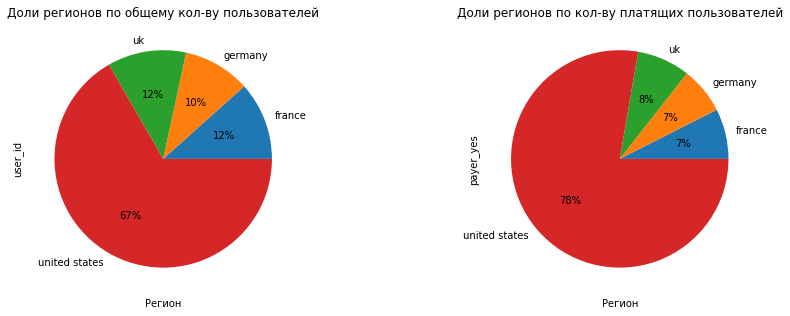

In [12]:
# строим график по кол-ву пользователей (регион)
# и кол-ву платящих пользователей

plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 2, 1)
profiles.groupby('region')['user_id'].count().plot(ax=ax1, kind='pie', autopct='%1.0f%%')
plt.xlabel('Регион')
plt.title('Доли регионов по общему кол-ву пользователей')

ax2 = plt.subplot(1, 2, 2)
profiles.groupby('region')['payer_yes'].sum().plot(ax=ax2, kind='pie', autopct='%1.0f%%')

plt.xlabel('Регион')
plt.title('Доли регионов по кол-ву платящих пользователей')
plt.show()

**ВЫВОДЫ ПО ИЗУЧЕННЫМ ДАННЫМ:**

* В разрезе регионов доминирующим лидером по количеству пользователей и платящих пользователей в общем объеме является США. Внутри региона доля платящих пользователей составляет 6,9%.

* Доли европейских стран приблизительно равны:
>
> Великобритания - 12% общего кол-ва пользователей / 8% среди платящих пользователей / доля платящих внутри страны 4%
>
> Франция - 12% общего кол-ва пользователей / 7% среди платящих пользователей / доля платящих внутри страны 3,8%
>
> Германия - 10% общего кол-ва пользователей / 7% среди платящих пользователей / доля платящих внутри страны 4,1%

In [13]:
# строим таблицу по кол-ву пользователей (устройство)
# и доле платящих
prof_payer_share_dev = (
    profiles.groupby('device')['user_id', 'payer_yes'].agg({'user_id':'count', 'payer_yes':'sum'})
    )
prof_payer_share_dev['payer_share'] = (prof_payer_share_dev['payer_yes'] / prof_payer_share_dev['user_id'] *100).round(1)

display(prof_payer_share_dev.sort_values(by='payer_share', ascending=False))

user_id  payer_yes  payer_share
device                                  
mac        30042       1912          6.4
iphone     54479       3382          6.2
android    35032       2050          5.9
pc         30455       1537          5.0

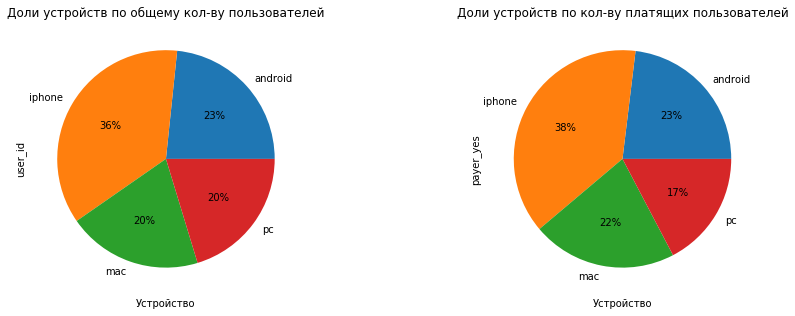

In [14]:
# строим график по кол-ву пользователей (устройство)
# и кол-ву платящих пользователей

plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 2, 1)
profiles.groupby('device')['user_id'].count().plot(ax=ax1, kind='pie', autopct='%1.0f%%')
plt.xlabel('Устройство')
plt.title('Доли устройств по общему кол-ву пользователей')

ax2 = plt.subplot(1, 2, 2)
profiles.groupby('device')['payer_yes'].sum().plot(ax=ax2, kind='pie', autopct='%1.0f%%')

plt.xlabel('Устройство')
plt.title('Доли устройств по кол-ву платящих пользователей')

plt.show()

**ВЫВОДЫ ПО ИЗУЧЕННЫМ ДАННЫМ:**

* В разрезе устройств нет доминирующих лидеров:

> iphone - 36% общего кол-ва пользователей / 38% среди платящих пользователей / доля платящих внутри страны 6,2%
>
> android - 23% общего кол-ва пользователей / 23% среди платящих пользователей / доля платящих внутри страны 5,9%
>
> mac - 20% общего кол-ва пользователей / 22% среди платящих пользователей / доля платящих внутри страны 6,4%
>
> pc - 20% общего кол-ва пользователей / 17% среди платящих пользователей / доля платящих внутри страны 5,0%

In [15]:
# строим таблицу по кол-ву пользователей (канал привлечения)
# и доле платящих
prof_payer_share_chan = (
    profiles.groupby('channel')['user_id', 'payer_yes'].agg({'user_id':'count', 'payer_yes':'sum'})
   )
prof_payer_share_chan['payer_share'] = (prof_payer_share_chan['payer_yes'] / prof_payer_share_chan['user_id'] *100).round(1)

display(prof_payer_share_chan.sort_values(by='payer_share', ascending=False))

user_id  payer_yes  payer_share
channel                                            
faceboom              29144       3557         12.2
adnonsense             3880        440         11.3
lambdamediaads         2149        225         10.5
tiptop                19561       1878          9.6
rocketsuperads         4448        352          7.9
wahoonetbanner         8553        453          5.3
yrabbit                4312        165          3.8
mediatornado           4364        156          3.6
leapbob                8553        262          3.1
opplecreativemedia     8605        233          2.7
organic               56439       1160          2.1

In [16]:
# проверяем регионы присутствия для каналов
chan_reg = profiles.pivot_table(
    index='channel', columns='region', values='user_id', aggfunc=('count'), margins=True).reset_index()

display(chan_reg.sort_values(by='united states', ascending=False))

region             channel   france  germany       uk  united states     All
11                     All  17450.0  14981.0  17575.0       100002.0  150008
6                  organic   6392.0   5453.0   6421.0        38173.0   56439
1                 faceboom      NaN      NaN      NaN        29144.0   29144
8                   tiptop      NaN      NaN      NaN        19561.0   19561
7           rocketsuperads      NaN      NaN      NaN         4448.0    4448
4             mediatornado      NaN      NaN      NaN         4364.0    4364
10                 yrabbit      NaN      NaN      NaN         4312.0    4312
0               adnonsense   1366.0   1219.0   1295.0            NaN    3880
2           lambdamediaads    742.0    649.0    758.0            NaN    2149
3                  leapbob   2988.0   2519.0   3046.0            NaN    8553
5       opplecreativemedia   2991.0   2562.0   3052.0            NaN    8605
9           wahoonetbanner   2971.0   2579.0   3003.0            NaN    8553

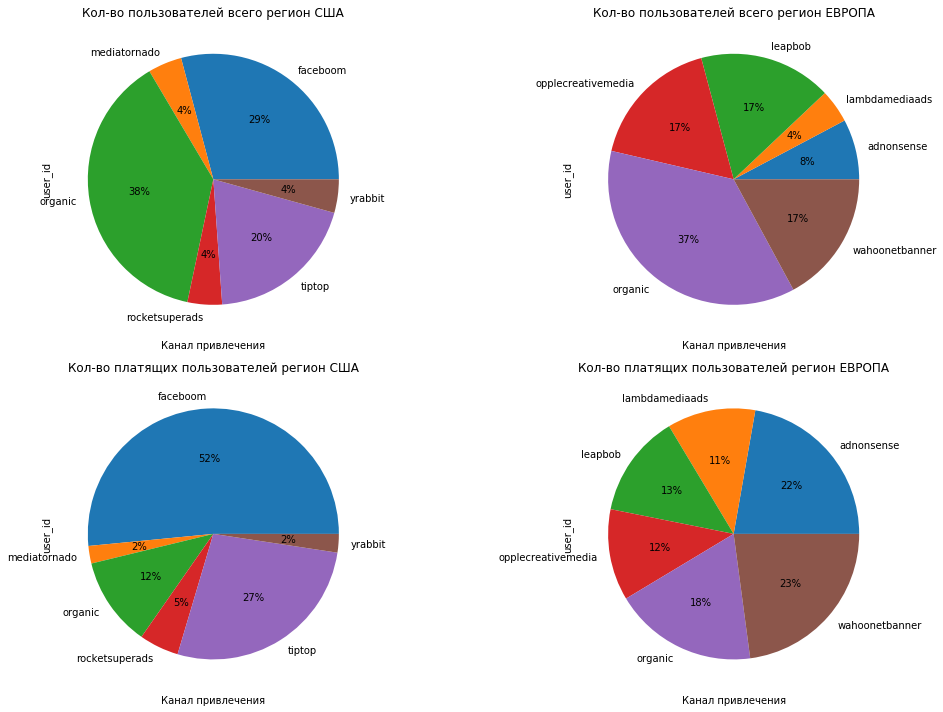

In [17]:
# строим график по кол-ву пользователей (канал привлечения)
# и кол-ву платящих пользователей с разбивкой на регионы присутствия

plt.figure(figsize=(15, 10))

ax1 = plt.subplot(2, 2, 1)
(
profiles.query('region == "united states"').groupby('channel')['user_id'].count()
     .plot(grid=True, ax=ax1, kind='pie', autopct='%1.0f%%')
)
plt.xlabel('Канал привлечения')
plt.title('Кол-во пользователей всего регион США')

ax2 = plt.subplot(2, 2, 2)
(
profiles.query('region != "united states"').groupby('channel')['user_id'].count()
     .plot(grid=True, ax=ax2, kind='pie', autopct='%1.0f%%')
)
plt.xlabel('Канал привлечения')
plt.title('Кол-во пользователей всего регион ЕВРОПА')

ax3 = plt.subplot(2, 2, 3)
(
profiles.query('region == "united states" & payer == True').groupby('channel')['user_id'].count()
     .plot(grid=True, ax=ax3, kind='pie', autopct='%1.0f%%')
)
plt.xlabel('Канал привлечения')
plt.title('Кол-во платящих пользователей регион США')

ax4 = plt.subplot(2, 2, 4)
(
profiles.query('region != "united states" & payer == True').groupby('channel')['user_id'].count()
     .plot(grid=True, ax=ax4, kind='pie', autopct='%1.0f%%')
)
plt.xlabel('Канал привлечения')
plt.title('Кол-во платящих пользователей регион ЕВРОПА')

plt.tight_layout()
plt.show()


**ВЫВОДЫ ПО ИЗУЧЕННЫМ ДАННЫМ:**

* В разрезе каналов привлечения анализ данных показал:
* всего привлечение неорганических пользователей осуществляется через 10 каналов
* каналы поделены на 2 ключевые группы:
> 5 каналов работают на привлечение пользователей в регионе США
>
> 5 каналов работают на привлечение пользователей в регионе Европа
* лидером по количеству привлеченных пользователей является органический канал с долей платящих внутри канала 2,1%:
> США = 38% от общего числа привлеченных пользователей / 12% среди платящих пользователей
>
> Европа = 37% от общего числа привлеченных пользователей / 18% среди платящих пользователей

* Среди платных каналов США явными лидерами являются:
> faceboom - 29% общего кол-ва пользователей / 52% среди платящих пользователей / доля платящих внутри страны 12,2%
>
> tiptop - 20% общего кол-ва пользователей / 27% среди платящих пользователей / доля платящих внутри страны 9,6%


* Среди платных каналов Европы нет доминирующих лидеров:
> fwahoonetbanner - 17% общего кол-ва пользователей / 23% среди платящих пользователей / доля платящих внутри страны 5,3%
>
> oppelcreativemedia - 17% общего кол-ва пользователей / 12% среди платящих пользователей / доля платящих внутри страны 2,7%
>
> leapbob - 17% общего кол-ва пользователей / 13% среди платящих пользователей / доля платящих внутри страны 3,1%

* Среди европейских каналов выделяется adnonsense, который при малой доле в общем портфеле клиентов имеет хорошую конверсию в платящих пользователей:
> adnonsense - 8% общего кол-ва пользователей / 22% среди платящих пользователей / доля платящих внутри страны 11,3%
>

### Выводы

Данные, предоставленные для анализа, включают в себя информацию о **150 008** пользователях, которые были привлечены и взимодействовали с приложением в период с *01.05.2019 г. по 27.10.2019 г.* в регионах:

>**США** = 67%
>
>**Великобритания** = 12%
>
>**Франция** = 12%
>
>**Германия** = 10%

8 881 пользователь, что составляет **6%** от общего числа, стал "покупающим". За предоставленный период процесс привлечения шел параллельно во всех регионах без временных сдвигов. Распределение долей платящих (покупающих) клиентов по регионам напоминает распределение общего количества пользователей:

>**США** = 78%
>
>**Великобритания** = 8%
>
>**Франция** = 7%
>
>**Германия** = 7%

Среди регионов безусловным лидером является США.

Среди устройств на первое место и по общему количеству пользователей, и по количеству платящих пользователей вышел iphone:

>**iphone** = 36% **/** 38% среди платящих
>
>**android** = 23% **/** 23% среди платящих
>
>**mac** = 20% **/** 21% среди платящих
>
>**pc** = 20% **/** 17% среди платящих

Продвижение проводится через 10 каналов (+ органический приход покупателей), которые поделены пополам по региональному принципу (США / Европа) и не пересекаются:

>**США** = faceboom, tiptop, rocketsuperads, mediatornado,   yrabbit
>
>**Европа** = wahoonetbanner, leapbob, opplecreativemedia, adnonsense, lambdamediaads 

В регионе США большинство клиентов приходят органически, из "платных" каналов лидером является faceboom:

>**organic** = 38% **/** 12% среди платящих
>
>**faceboom** = 29% **/** 52% среди платящих
>
>**tiptop** = 20% **/** 27% среди платящих
>
>**rocketsuperads** = 4% **/** 5% среди платящих
>
>**mediatornado** = 4% **/** 2% среди платящих
>
>**yrabbit** = 4% **/** 2% среди платящих

В регионе ЕВРОПА большинство клиентов также приходят органически, распределение между платными каналами является более равномерным:

>**organic** = 37% **/** 19% среди платящих
>
>**wahoonetbanner** = 17% **/** 23% среди платящих
>
>**leapbob** = 17% **/** 13% среди платящих
>
>**opplecreativemedia** = 17% **/** 12% среди платящих
>
>**adnonsense** = 8% **/** 22% среди платящих
>
>**lambdamediaads** = 4% **/** 11% среди платящих

В группе "европейских каналов" следует обратить внимание на последние 2, которые при низком показателе общего привлечения имеют на фоне остальных каналов высокую долю конвертации в платящего клиента.


## Построение отчётов и расчет метрик

### Продукт:

-    **Сколько людей пользуются в день, неделю, месяц?**

In [18]:
# добавляем в таблицу visits колонки session_date, session_week, session_month

visits['session_date'] = visits['session_start'].dt.date
visits['session_week'] = visits['session_start'].dt.week
visits['session_month'] = visits['session_start'].dt.month

display(visits.sort_values(by='session_month').head(5))

user_id         region  device         channel  \
0       981449118918  united states  iphone         organic   
222587  618628270635             uk  iphone         leapbob   
222586  631256661190        germany      pc         organic   
222585  566958668876         france     mac  wahoonetbanner   
222584  666830407247         france     mac  wahoonetbanner   

             session_start         session_end session_date  session_week  \
0      2019-05-01 02:36:00 2019-05-01 02:45:00   2019-05-01            18   
222587 2019-05-31 00:53:00 2019-05-31 01:02:00   2019-05-31            22   
222586 2019-05-31 11:16:00 2019-05-31 11:18:00   2019-05-31            22   
222585 2019-05-31 02:24:00 2019-05-31 03:05:00   2019-05-31            22   
222584 2019-05-31 12:49:00 2019-05-31 14:31:00   2019-05-31            22   

        session_month  
0                   5  
222587              5  
222586              5  
222585              5  
222584              5

count     184.000000
mean     1684.239130
std       324.247388
min       724.000000
25%      1462.000000
50%      1682.000000
75%      1870.750000
max      2493.000000
Name: user_id, dtype: float64

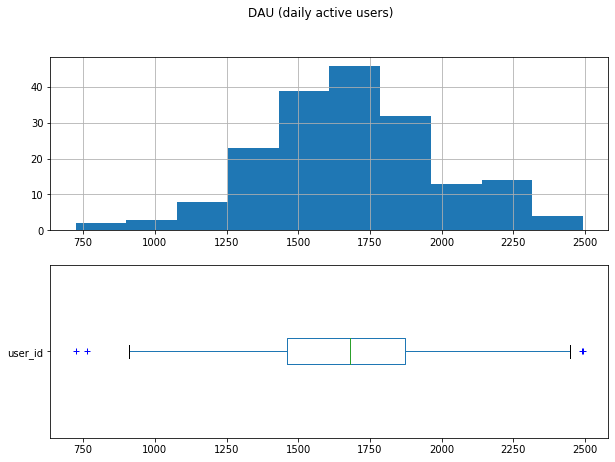

In [19]:
# изучаем стат параметры распределения пользователей по дням

display(visits.groupby('session_date')['user_id'].nunique().describe())

# строим гистограмму и диаграмму размаха
fig, axs = plt.subplots(2)
fig.set_figheight(7)
fig.set_figwidth(10)
fig.suptitle('DAU (daily active users)')
visits.groupby('session_date')['user_id'].nunique().hist(ax=axs[0])
visits.groupby('session_date')['user_id'].nunique().plot(kind='box',vert=False,ax=axs[1],sym='b+')
plt.show()

**ВЫВОДЫ ПО ГРАФИКАМ:**

* Распределение значений стремится к нормальному, без выбросов.

* Значения медианы и среднего близки. 

* Среднее равно: 1 684 пользователя. 

* Минимальное значение: 724 пользователя в день.

* Максимальное значение: 2 493 пользователя.

count       27.000000
mean      8353.777778
std       1897.567681
min       3118.000000
25%       7480.000000
50%       8434.000000
75%       9377.500000
max      11720.000000
Name: user_id, dtype: float64

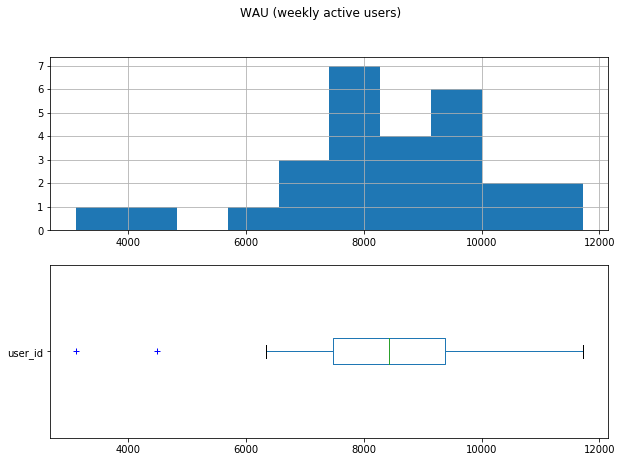

In [20]:
# изучаем стат параметры распределения пользователей по неделям

display(visits.groupby('session_week')['user_id'].nunique().describe())

# строим гистограмму и диаграмму размаха
fig, axs = plt.subplots(2)
fig.set_figheight(7)
fig.set_figwidth(10)
fig.suptitle('WAU (weekly active users)')
visits.groupby('session_week')['user_id'].nunique().hist(ax=axs[0])
visits.groupby('session_week')['user_id'].nunique().plot(kind='box',vert=False,ax=axs[1],sym='b+')
plt.show()

**ВЫВОДЫ ПО ГРАФИКАМ:**

* Распределение значений по количеству пользователей в неделю является не нормальным,скошено влево, имеет выбросы.

* Медиана равна: 8 434 пользователя в неделю.

* Минимальное значение: 3 118 пользователей.

* Максимально значение: 11 720 пользователей.

count        6.000000
mean     28989.166667
std       2644.629533
min      26042.000000
25%      26781.750000
50%      29087.500000
75%      31147.250000
max      31871.000000
Name: user_id, dtype: float64

session_month
5     27111
6     26042
7     26672
8     31064
9     31871
10    31175
Name: user_id, dtype: int64

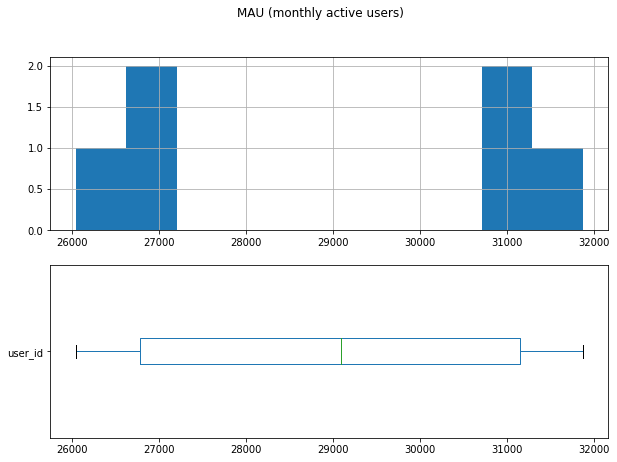

In [21]:
# изучаем стат параметры колонки session_month

display(visits.groupby('session_month')['user_id'].nunique().describe())
display(visits.groupby('session_month')['user_id'].nunique())

# строим гистограмму и диаграмму размаха
fig, axs = plt.subplots(2)
fig.set_figheight(7)
fig.set_figwidth(10)
fig.suptitle('MAU (monthly active users)')
visits.groupby('session_month')['user_id'].nunique().hist(ax=axs[0])
visits.groupby('session_month')['user_id'].nunique().plot(kind='box',vert=False,ax=axs[1],sym='b+')
plt.show()

**ВЫВОДЫ ПО ГРАФИКАМ:**

* Распределение значений разбито на 2 группы, без выбросов.

* 1-я группа: 26 - 27 тысяч пользователей.

* 2-я группа: 31 - 32 тысячи пользователей.

* Среднее равно: 28 989 пользователей в месяц.

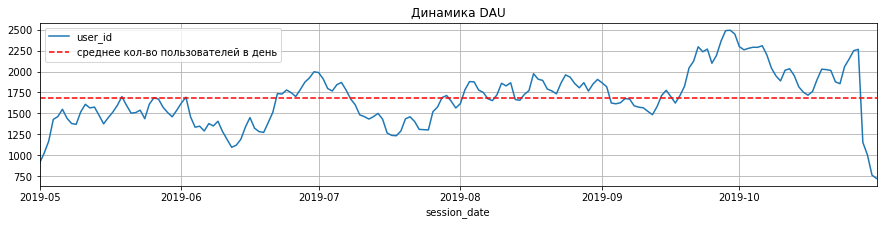

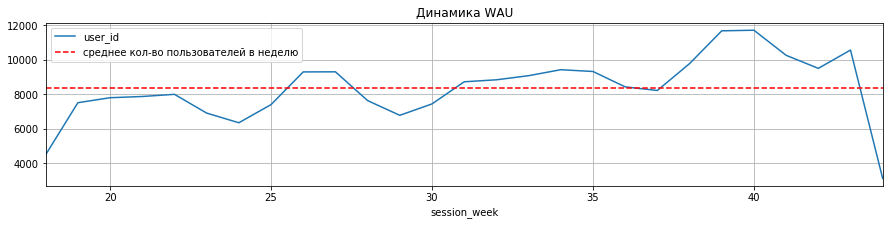

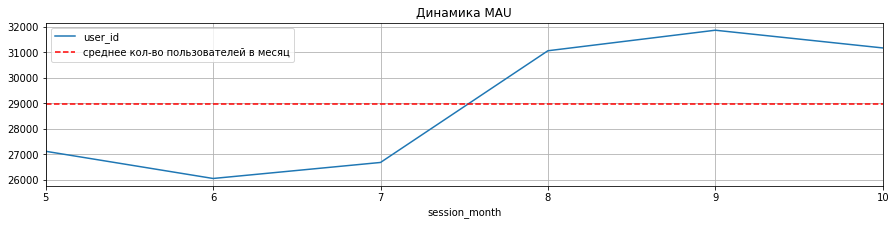

In [22]:
# строим графики изменения метрик DAU, WAU, MAU во времени

visits.groupby('session_date')['user_id'].nunique().plot(grid=True, title='Динамика DAU', figsize=(15,3))
plt.axhline(
    y=visits.groupby('session_date')['user_id'].nunique().mean(), color='red',
    linestyle='--', label='среднее кол-во пользователей в день')
plt.legend()
plt.show()

visits.groupby('session_week')['user_id'].nunique().plot(grid=True, title='Динамика WAU', figsize=(15,3))
plt.axhline(
    y=visits.groupby('session_week')['user_id'].nunique().mean(), color='red',
    linestyle='--', label='среднее кол-во пользователей в неделю')
plt.legend()
plt.show()

visits.groupby('session_month')['user_id'].nunique().plot(grid=True, title='Динамика MAU', figsize=(15,3))
plt.axhline(
    y=visits.groupby('session_month')['user_id'].nunique().mean(), color='red',
    linestyle='--', label='среднее кол-во пользователей в месяц')
plt.legend()
plt.show()

**ВЫВОДЫ ПО ГРАФИКАМ:**

* Динамика DAU кольблется вдоль среднего значения с трендом на снижение с конца сентября.

* Динамика WAU повторяет тренд DAU.

* Динамика MAU показывает значения ниже среднего в период с мая по середину июля. В июле начинается рост, продолжающийся до сентября. В сентябре намечается тренд на снижение.

-    **Сколько сессий в день?**

count     184.000000
mean     1684.244565
std       324.254386
min       724.000000
25%      1462.000000
50%      1682.000000
75%      1870.750000
max      2493.000000
Name: session_start, dtype: float64

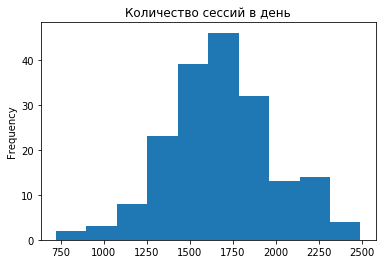

In [23]:
# рассчитываем кол-во сессий в день,
# выводим стат информацию

display(visits.groupby('session_date')['session_start'].count().describe())

# строим гистограмму

visits.groupby('session_date')['session_start'].count().plot(kind = 'hist', title='Количество сессий в день')

plt.show()

**ВЫВОДЫ ПО ГРАФИКУ:**

* Распределение значений стремится к нормальному.

* Количество сессий в день находится в диапазоне от 724 до 2 493.

* 75% значений сосредоточены в интервале до 724 до 1 870.

* Выбросов не наблюдается, значения медианы и среднего близки.

* Среднее равно: 1 684 сессиям. Данные Совпадают с количеством уникальных пользователей в день.

-    **Сколько длится одна сессия?**

In [24]:
# рассчитываем параметры сессий,
# добавляем в таблицу visits колонку session_dur

visits['session_dur'] = (visits['session_end'] - visits['session_start']).dt.seconds
display(visits.sample(2))

user_id         region device  channel       session_start  \
244770  429631568825         france    mac  leapbob 2019-07-14 14:45:00   
194901  226226907064  united states    mac  organic 2019-10-20 18:19:00   

               session_end session_date  session_week  session_month  \
244770 2019-07-14 15:48:00   2019-07-14            28              7   
194901 2019-10-20 18:49:00   2019-10-20            42             10   

        session_dur  
244770         3780  
194901         1800

In [25]:
# изучаем стат параметры колонки session_dur

visits['session_dur'].describe()

count    309901.000000
mean       1800.084801
std        1803.189827
min           0.000000
25%         540.000000
50%        1260.000000
75%        2520.000000
max       22260.000000
Name: session_dur, dtype: float64

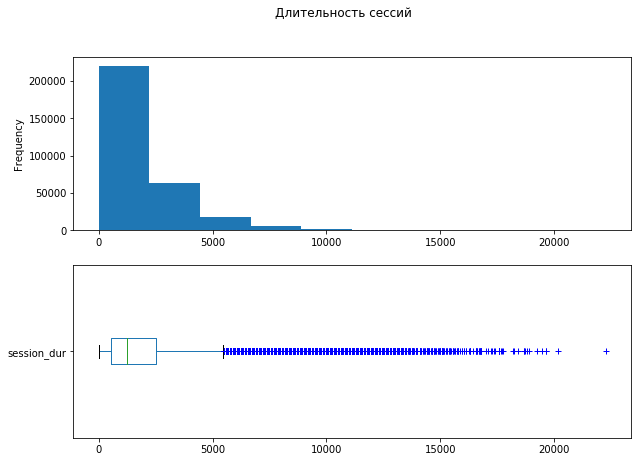

In [26]:
# строим гистограмму и диаграмму размаха

fig, axs = plt.subplots(2)
fig.set_figheight(7)
fig.set_figwidth(10)
fig.suptitle('Длительность сессий')
visits['session_dur'].plot.hist(ax=axs[0])
visits['session_dur'].plot(kind='box',vert=False,ax=axs[1],sym='b+') 
plt.show()

**ВЫВОДЫ ПО ГРАФИКАМ:**

* Гистограмма имеет форму распределения Пуассона.

* Длительность сессий представлена широким диапазоном от 0 до 22 260 секунд.

* Имеется длинный хвост за пределами 5 000 секунд.

* 75% значений сосредоточены в интервале до 2 520 секунд. 

* Медиана равна: 1 260 секунд, или 21 минуте.

count    84168.000000
mean       269.016966
std        164.779313
min          0.000000
25%        120.000000
50%        240.000000
75%        420.000000
max        540.000000
Name: session_dur, dtype: float64

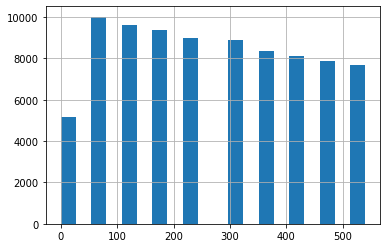

In [27]:
# изучаем сессии в интервале первого квартиля (540 сек)

visits_short = visits.query('session_dur <= 540')
display(visits_short['session_dur'].describe())
visits_short['session_dur'].hist(bins=20)
plt.show()

**ВЫВОДЫ ПО ГРАФИКУ:**

Так как приложение является развлекательным вызывают вопрос 5 000 сессий, длившихся меньше 1 минуты

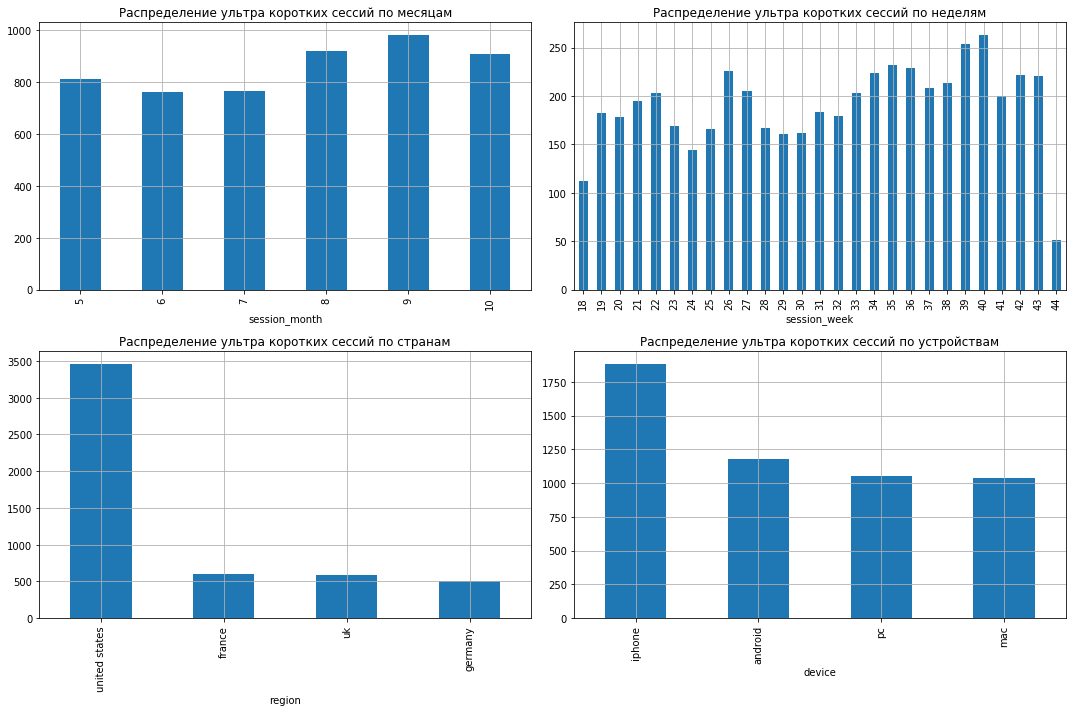

In [28]:
# проверяем как сессии меньше 1 минуты распределены по стрнам, устройствам и во времени

visits_short_ultra = visits.query('session_dur < 60')

plt.figure(figsize=(15, 10))

ax3 = plt.subplot(2, 2, 3)
visits_short_ultra.groupby('region')['session_dur'].count().sort_values(ascending=False).plot(ax=ax3, kind='bar', grid=True)
plt.title('Распределение ультра коротких сессий по странам')

ax4 = plt.subplot(2, 2, 4)
visits_short_ultra.groupby('device')['session_dur'].count().sort_values(ascending=False).plot(ax=ax4, kind='bar', grid=True)
plt.title('Распределение ультра коротких сессий по устройствам')

ax1 = plt.subplot(2, 2, 1)
visits_short_ultra.groupby('session_month')['session_dur'].count().plot(ax=ax1, kind='bar', grid=True)
plt.title('Распределение ультра коротких сессий по месяцам')                                                                                              

ax2 = plt.subplot(2, 2, 2)
visits_short_ultra.groupby('session_week')['session_dur'].count().plot(ax=ax2, kind='bar', grid=True)
plt.title('Распределение ультра коротких сессий по неделям')                                                                                                      

plt.tight_layout()
plt.show()

**ВЫВОДЫ ПО ГРАФИКАМ:**

* Распределение ультра коротких сессий во времени показывает, что во второй половине анализируемого периода (август - октябрь) количество таких сессий незначительно, но выросло, с пиком в сентябре.

* Распределение ультра коротких сессий по странам и устройствам пропорционально соответствует распределению клиентской базы.

#### Выводы

* **Сколько людей пользуются в день, неделю, месяц** - **DAU (daily active users)** - распределение значений стремится к нормальному, без выбросов. Значения медианы и среднего близки. Решено принять **среднее** значение количества пользователей для определения количества пользователей в день, что равно *1 684* пользователям. **WAU (weekly active users)** - распределение значений по количеству пользователей в неделю является не нормальным,скошено влево, имеет выбросы. Решено принять **медианное** значение количества пользователей для определения количества пользователей в неделю, что равно *8 434* пользователям. **MAU (monthly active users)** - распределение значений рваное, без выбросов, равномерно распределенное. Решено принять **среднее** значение количества пользователей для определения количества пользователей в месяц, что равно *28 989* пользователей. Динамика метрик показывает тренд на снижение с сентября.


* **Сколько сессий в день** - количество сессий в день находится в диапазоне от *724* до *2 493*. 75% значений сосредоточены в интервале до *724* до *1 870*. Выбросов не наблюдается, значения медианы и среднего близки. Решено принять **среднее** значение количества сессий для определения количества сессий в день, что равно *1 684* сессиям. Данные Совпадают с количеством уникальных пользователей в день, что свидетельствует о том, что пользователи повторно не заходят в приложение в течении дня.


* **Сколько длится одна сессия** - длительность сессий представлена широким диапазоном от *0* до *22 260* секунд. Имеется длинный хвост за пределами *5 000* секунд. 75% значений сосредоточены в интервале до *2 520* секунд. В связи с наличием выбросов решено принять **медианное** значение для определения средней длительности сессии, что равно *1 260* секундам, или *21* минуте. Ультра короткие сессии меньше 1 минуты составили порядка 1,7% от общего количества сессий. Причина ультра коротких сессий скорее всего является смешанной: быстрая оценка контента новым пользователем и отсутствие интереса + вероятные технические сложности. Учитывая низкий процент таких случаев и их равномерное распределение во времени можно предположить, что первая причина доминирует и устойчивой технической проблемы нет.


### Продажи:

- **Когда люди начинают покупать?**

In [29]:
# добавляем в таблицу orders колонки event_date, event_week, event_month

orders['event_date'] = orders['event_dt'].dt.date
orders['event_week'] = orders['event_dt'].dt.week
orders['event_month'] = orders['event_dt'].dt.month

display(orders.sort_values(by='event_month').sample(5))

user_id            event_dt  revenue  event_date  event_week  \
8771   433160376727 2019-07-21 13:24:13     4.99  2019-07-21          29   
13188  477923117742 2019-08-18 22:47:59     4.99  2019-08-18          33   
33478  846584433493 2019-08-19 02:17:20     4.99  2019-08-19          34   
7316   159720177938 2019-07-11 21:21:54     4.99  2019-07-11          28   
8443   751222911384 2019-07-19 00:41:18     4.99  2019-07-19          29   

       event_month  
8771             7  
13188            8  
33478            8  
7316             7  
8443             7

In [30]:
# определяем момент первой сессии для user_id в таблице visits
# определяем момент первой покупки для user_id в таблице orders
session_first = visits.groupby('user_id')['session_start'].min().to_frame()
purch_first = orders.groupby('user_id')['event_dt'].min().to_frame()

# объединяем данные,
# приводим к формату datetime

purch_per = session_first.merge(purch_first, on='user_id').reset_index()
purch_per['session_start'] = pd.to_datetime(purch_per['session_start'], format='%Y-%m-%d %H:%M')
purch_per['event_dt'] = pd.to_datetime(purch_per['event_dt'], format='%Y-%m-%d %H:%M:%S')

# рассчитываем период между первой сессией и первой покупкой в днях
purch_per['period_days'] = (purch_per['event_dt'] - purch_per['session_start']).dt.days

# рассчитываем период между первой сессией и первой покупкой в минутах
purch_per['period_min'] = (purch_per['event_dt'] - purch_per['session_start']).dt.total_seconds() / 60

# выводим стат данные по колонкам period_days, period_min
display(purch_per['period_days'].describe(),purch_per['period_min'].describe())

count    8881.000000
mean        1.702511
std         5.944318
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       132.000000
Name: period_days, dtype: float64

count      8881.000000
mean       2711.844884
std        8692.336097
min           0.000000
25%           0.683333
50%           1.166667
75%        2128.866667
max      190314.916667
Name: period_min, dtype: float64

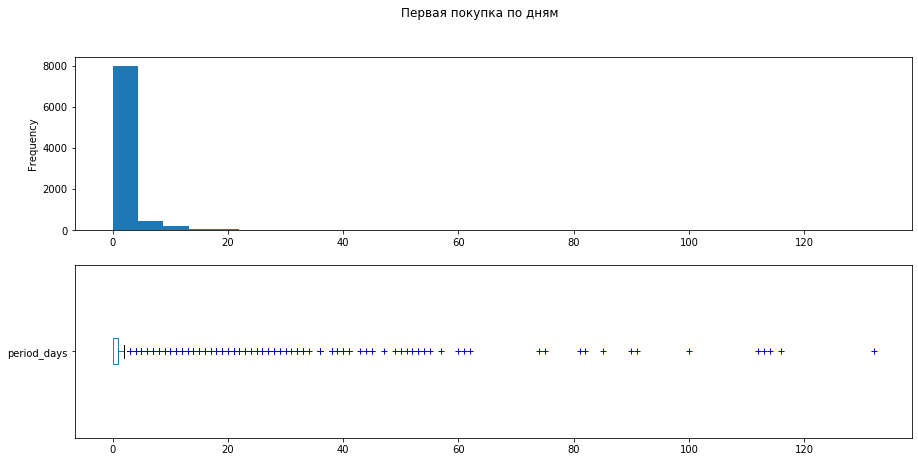

In [31]:
# строим гистограмму и диаграмму размаха по дням

fig, axs = plt.subplots(2)
fig.set_figheight(7)
fig.set_figwidth(15)
fig.suptitle('Первая покупка по дням')
purch_per['period_days'].plot(ax=axs[0],kind= 'hist', bins = 30)
purch_per['period_days'].plot(kind='box',vert=False,ax=axs[1],sym='b+')
plt.show()

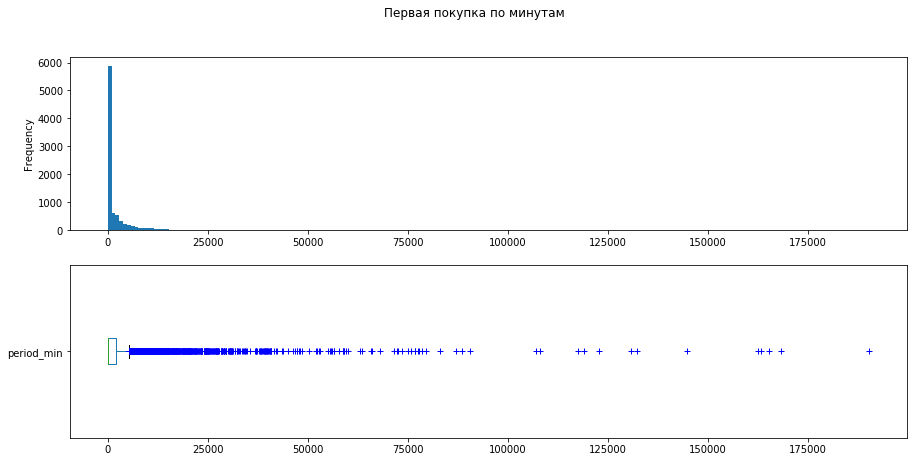

In [32]:
# строим гистограмму и диаграмму размаха по минутам

fig, axs = plt.subplots(2)
fig.set_figheight(7)
fig.set_figwidth(15)
fig.suptitle('Первая покупка по минутам')
purch_per['period_min'].plot.hist(ax=axs[0], bins=200)
purch_per['period_min'].plot(kind='box',vert=False,ax=axs[1],sym='b+')
plt.show()

**ВЫВОДЫ ПО ИЗУЧЕННЫМ ДАННЫМ И ГРАФИКАМ:**

* Гистограммы имеют форму распределения Пуассона.

* Гисторамма и диаграмма рассеивания по дням показывают, что 50% покупок происходят в день первой сессии, +25% на следующий день.

* Имеется длинный хвост и выбросы. Максимальное значение: 133 дня.

* Гисторамма и диаграмма рассеивания по минутам показывают, что принятие решения о покупке происходит у пользователей достаточно быстро, на 2-й минуте знакомства с приложением.

* Имеется длинный хвост и выбросы. Медианное значение 1,17 мин принято за среднее.

* 75% значений находятся в диапазоне до 2 129 мин, что коррелирует с оценкой по дням.

- **Сколько покупок делает в среднем платящий пользователь за месяц, неделю, день?**

In [33]:
# рассчитываем среднее кол-во покупок платящего пользователя в день

display(orders.groupby(['user_id', 'event_date'])['event_dt'].count().describe())

count    40210.000000
mean         1.000050
std          0.007052
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: event_dt, dtype: float64

**ВЫВОДЫ ПО РАСЧЕТАМ:**

Статистический анализ данных показал, что **в среднем платящий пользователь делает 1 покупку в день**. 75% значений соответствуют 1. Максимальное значение равно 2, медианное и среднее значения совпадают. Дисперсия стремится к 0.

In [34]:
# рассчитываем среднее кол-во покупок платящего пользователя в неделю

pur_avg_week = orders.groupby('event_week')['event_dt'].count() / orders.groupby('event_week')['user_id'].nunique()
display(pur_avg_week.describe())

count    27.000000
mean      1.326663
std       0.080576
min       1.121775
25%       1.288063
50%       1.313904
75%       1.355114
max       1.526882
dtype: float64

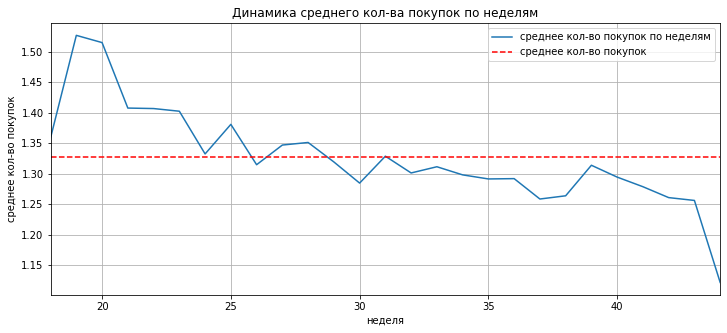

In [35]:
# строим график изменения среднего кол-ва покупок платящего пользователя по неделям

pur_avg_week.plot(figsize=(12,5), grid=True, label='среднее кол-во покупок по неделям')
plt.axhline(y=pur_avg_week.mean(), color='red', linestyle='--', label='среднее кол-во покупок')
plt.title("Динамика среднего кол-ва покупок по неделям")
plt.xlabel('неделя')
plt.ylabel("среднее кол-во покупок")
plt.legend()
plt.show()

**ВЫВОДЫ ПО ГРАФИКУ:**

* Динамика среднего кол-ва покуплок по неделям имеет общий тренд на снижение.

* Максимальное значение достигнуто на 19 неделе: 1,52 покупки.

* Минимальное значение на 45 неделе: 1.

* До 29 недели значения находтся в диапазоне выше среднего: 1,34.

* 29 - 45 недели значения не поднимаются выше среднего.

In [36]:
# рассчитываем кол-во покупок платящего пользователя в месяц

pur_avg_month = orders.groupby('event_month')['event_dt'].count() / orders.groupby('event_month')['user_id'].nunique()
display(pur_avg_month.describe())

count    6.000000
mean     2.228448
std      0.144278
min      2.044132
25%      2.120311
50%      2.234988
75%      2.327628
max      2.415987
dtype: float64

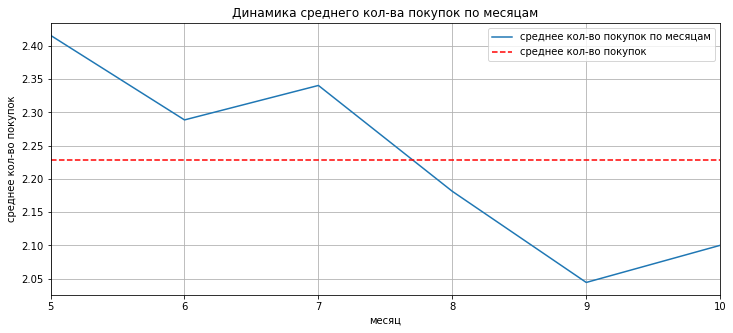

In [37]:
# строим график изменения среднего кол-ва покупок платящего пользователя по месяцам

pur_avg_month.plot(figsize=(12,5), grid=True, label='среднее кол-во покупок по месяцам')
plt.axhline(y=pur_avg_month.mean(), color='red', linestyle='--', label='среднее кол-во покупок')
plt.title("Динамика среднего кол-ва покупок по месяцам")
plt.xlabel('месяц')
plt.ylabel("среднее кол-во покупок")
plt.legend()
plt.show()

**ВЫВОДЫ ПО ГРАФИКУ:**

* Динамика изменения среднего кол-ва покупок по месяцам имеет отрицательный тренд.

* Самое большое кол-во покупок было в мае: 2,42.

* Самое маленькое кол-во покупок было в конце августа: 2.04.

* В июле после июньского падения произошел всплеск до 2,34.

* С середины июля кривая не поднимается выше среднего:  2,23.

- **Какой средний чек за месяц, неделю, день?**

In [38]:
# рассчитываем средний чек за день

display(orders.groupby('event_date')['revenue'].mean().describe())

count    184.000000
mean       5.375884
std        0.246025
min        4.990000
25%        5.185476
50%        5.335974
75%        5.544885
max        6.204286
Name: revenue, dtype: float64

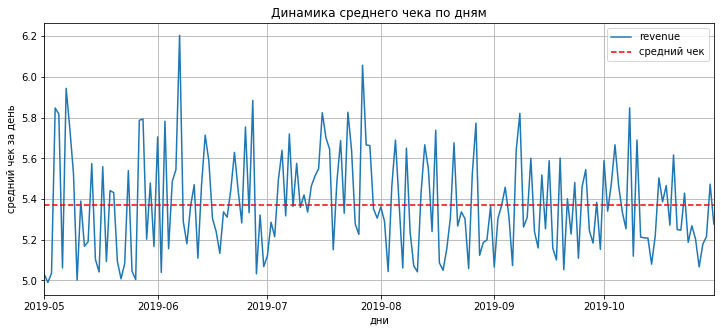

In [39]:
# строим график поведения среднего чека за день

orders.groupby('event_date')['revenue'].mean().plot(figsize=(12,5), grid=True)
plt.axhline(y=orders['revenue'].mean(), color='red', linestyle='--', label='средний чек')
plt.title("Динамика среднего чека по дням")
plt.xlabel('дни')
plt.ylabel("средний чек за день")
plt.legend()
plt.show()

**ВЫВОДЫ ПО ГРАФИКУ:**

* Значения находятся в диапазоне от 4,99 до 6,20 со средним значением 5,38.

* Динамика характеризуется постоянным колебанием.

* Самое большое количество провалов к линии минимума отмечается в мае.

* Максимальное значение приходится на первые числа июня.

In [40]:
# рассчитываем средний чек за неделю

display(orders.groupby('event_week')['revenue'].mean().describe())

count    27.000000
mean      5.376336
std       0.095871
min       5.162030
25%       5.305387
50%       5.370992
75%       5.430414
max       5.581851
Name: revenue, dtype: float64

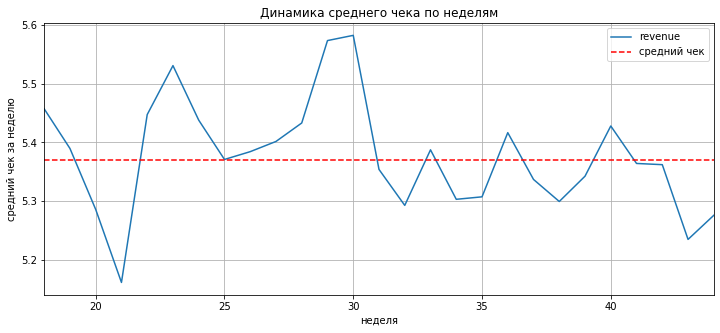

In [41]:
# строим график поведения среднего чека за неделю

orders.groupby('event_week')['revenue'].mean().plot(figsize=(12,5), grid=True)
plt.axhline(y=orders['revenue'].mean(), color='red', linestyle='--', label='средний чек')
plt.title("Динамика среднего чека по неделям")
plt.xlabel('неделя')
plt.ylabel("средний чек за неделю")
plt.legend()
plt.show()

**ВЫВОДЫ ПО ГРАФИКУ:**

* Значения находятся в диапазоне от 5,16 до 5,58 со средним значением 5,38.

* Минимальное значение пришлось на 21 неделю, максимальное - на 30.

* 23 - 31 недели чек находился на уровне среднего или выше.

* С 31 по 42 неделю колебания происходили вдоль линии среднего.

In [42]:
# рассчитываем средний чек за месяц

display(orders.groupby('event_month')['revenue'].mean().describe())

count    6.000000
mean     5.374169
std      0.066684
min      5.328565
25%      5.330270
50%      5.337955
75%      5.402071
max      5.489390
Name: revenue, dtype: float64

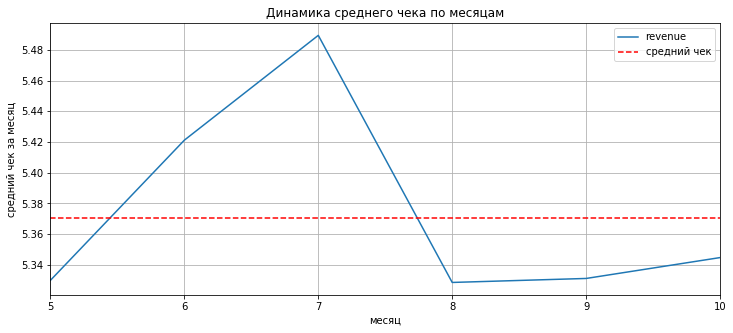

In [43]:
# строим график поведения среднего чека за месяц

orders.groupby('event_month')['revenue'].mean().plot(figsize=(12,5), grid=True)
plt.axhline(y=orders['revenue'].mean(), color='red', linestyle='--', label='средний чек')
plt.title("Динамика среднего чека по месяцам")
plt.xlabel('месяц')
plt.ylabel("средний чек за месяц")
plt.legend()
plt.show()

**ВЫВОДЫ ПО ГРАФИКУ:**

* значения находятся в диапазоне от 5,33 до 5,5 со средним значением 5,37.

* Минимальные значения приняли на себя май и август, максимальное - июль.

* В период с середины мая до последней трети июля чек находился в зоне выше среднего, остальные периоды - ниже.

#### Выводы

* **Когда люди начинают покупать** - из 8 881 покупок 50% были сделаны в день первой сессии, +25% на следующий день. Оценка скорости принятия решений по минутам показала, что в среднем покупка происходит на 2-ой минуте знакомства с приложением, что свидетельствует о том, что "спонтанно" приложение нравится пользователям и контент вызывает быстрый отклик.

* **Сколько покупок делает в среднем платящий пользователь за месяц, неделю, день** - Продажи стартуют на 18 неделе. Диапазон значений количества средних покупок находится между **1,12** и **1,53** со средним значением **1,33** покупки в неделю. Пик приходится на 19 неделю после чего начинается устойчивый тренд на снижение. По 26 неделю значения находятся в зоне выше среднего. Начиная с 29 недели значения выше среднего не поднимаются. На уровне месяца диапазон значений количества средних покупок находится между **2,04** и **2,42** со средним значением **2,23** покупки в месяц. Пик приходится на первый месяц - май после чего начинается устойчивый тренд на снижение, повторяющий недельный. С мая по конец июля значения находятся в зоне выше среднего. С конца июля по октябрь - ниже. Минимальное значение приходится на сентябрь, после чего происходит небольшой отскок.

* **Среднее количество покупок платящего пользователя в:**

>ДЕНЬ = 1
>
>НЕДЕЛЯ = 1,3
>
>МЕСЯЦ = 2,2

* **Средний чек за день** - значения находятся в диапазоне от **4,99** до **6,20** со средним значением **5,38**. Динамика характеризуется постоянным колебанием. Самое большое количество провалов к линии минимума отмечается в мае. Максимальное значение приходится на первые числа июня.

* **Средний чек за неделю** - значения находятся в диапазоне от **5,16** до **5,58** со средним значением **5,38**. Минимальное значение пришлось на 21 неделю, максимальное - на 30. 23 - 31 недели чек находился на уровне среднего или выше. С 31 по 42 неделю колебания происходили вдоль линии среднего.

* **Средний чек за месяц** - значения находятся в диапазоне от **5,33** до **5,5** со средним значением **5,37**. Минимальные значения приняли на себя май и август, максимальное - июль. В период с середины мая до последней трети июля чек находился в зоне выше среднего, остальные периоды - ниже.

### Маркетинг:


- **Сколько денег потратили? Всего / на каждый источник / по времени**

In [44]:
# рассчитываем общую сумму расходов на маркетинг
print('Общая сумма затрат на продвижение:', costs['costs'].sum().round())

Общая сумма затрат на продвижение: 105497.0


In [45]:
# рассчитываем распределение трат по каналам
chan_cost = costs.groupby('channel')['costs'].sum().sort_values(ascending=False).reset_index()

chan_cost['share'] = (chan_cost['costs'] / 105497).round(2)
display(chan_cost)

channel     costs  share
0              tiptop  54751.30   0.52
1            faceboom  32445.60   0.31
2      wahoonetbanner   5151.00   0.05
3          adnonsense   3911.25   0.04
4  opplecreativemedia   2151.25   0.02
5      rocketsuperads   1833.00   0.02
6             leapbob   1797.60   0.02
7      lambdamediaads   1557.60   0.01
8        mediatornado    954.48   0.01
9             yrabbit    944.22   0.01

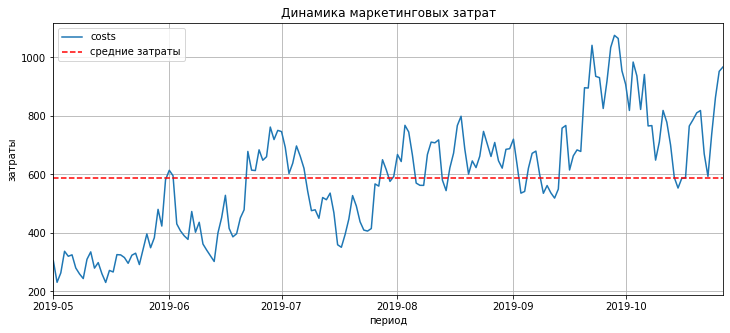

In [46]:
# анализируем динамику затрат во времени,
# строим график

costs.groupby('dt')['costs'].sum().plot(figsize=(12,5), grid=True)
plt.axhline(y=costs.groupby('dt')['costs'].sum().mean(), color='red', linestyle='--', label='средние затраты')
plt.title("Динамика маркетинговых затрат")
plt.xlabel('период')
plt.ylabel("затраты")
plt.legend()
plt.show()

**ВЫВОДЫ ПО ГРАФИКУ:**

* Динамика затрат имеет общий тренд роста с минимальным значением в начале мая и максимальным - в конце сентября.

* Во второй половине проекта начиная с конца июля затраты практически не опускаются ниже среднего.

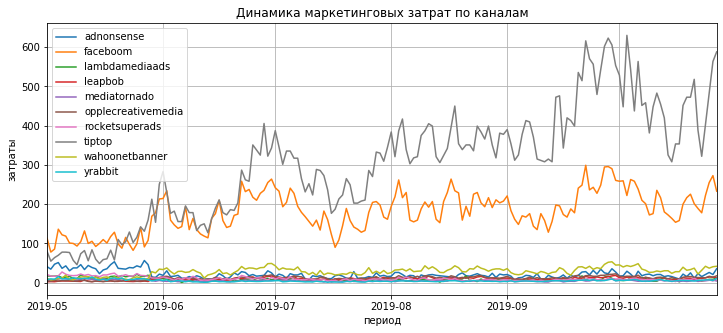

In [47]:
# анализируем динамику затрат во времени по каналам,
# строим график

costs.pivot_table(index='dt', columns='channel', values='costs', aggfunc=('sum')).plot(figsize=(12,5), grid=True)
plt.title("Динамика маркетинговых затрат по каналам")
plt.xlabel('период')
plt.ylabel("затраты")
plt.legend()
plt.show()

**ВЫВОДЫ ПО ГРАФИКУ:**

* Самыми инвестируемыми каналами стали tiptop (США) и faceboom (США).

* adnonsense (Европа) на старте проекта в мае шел на 3-м месте, но к концу месяца инвестиции в него снизились до уровня остального большинства.

* В конце мая вместе со снижением ивестиций в adnonsense подросли инвестиции в wahoonetbanner (Европа). Очевидно между ними произошло перераспределение бюджета.

* Инвестиции в остальные 6 каналов находятся приблизительно на одном уровне без каких-либо явных всплексов или провалов.

- **Сколько в среднем стоило привлечение одного пользователя из каждого источника?**

**Расчет CAC на каждого пользователя для всего проекта:**

In [48]:
# дорабатываем функцию для построения профилей

def get_profiles(visits, orders, costs):
 # сортируем сессии по ID пользователя и дате привлечения
 # группируем по ID и находим параметры первых посещений
    profiles = (
     visits.sort_values(by=['user_id', 'session_start'])
     .groupby('user_id')
     .agg(
     {
     'session_start': 'first',
     'session_end': 'last',
     'channel': 'first',
     'device': 'first',
     'region': 'first',
     }
     )
# время первого посещения называем first_ts
     .rename(columns={'session_start': 'first_ts'})
# время последнего посещения называем last_ts
     .rename(columns={'session_end': 'last_ts'})
# возвращаем user_id из индекса     
     .reset_index() 
 )
# добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
# добавляем колонки "payer_yes", "payer_no"
    profiles['payer_yes'] = (profiles['payer'] == True).astype(int)
    profiles['payer_no'] = (profiles['payer'] == False).astype(int)
# для когортного анализа определяем дату первого посещения и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
# считаем количество уникальных пользователей с одинаковыми источником и датой привлечения
    new_users = (
    profiles.groupby(['dt', 'channel'])
    .agg({'user_id': 'nunique'})
# называем колонку с числом пользователей unique_users
    .rename(columns={'user_id': 'unique_users'})
    .reset_index() # возвращаем dt и channel из индексов
)
# объединяем траты на рекламу и число привлечённых пользователей по дате и каналу привлечения
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
# делим рекламные расходы на число привлечённых пользователей
# результаты сохраняем в столбец acquisition_cost (CAC)
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']
# добавляем стоимость привлечения в профили
    profiles = profiles.merge(
    costs[['dt', 'channel', 'acquisition_cost']],
    on=['dt', 'channel'],
    how='left',
)
# для органических пользователей в колонке acquisition_cost заменяем значения NaN на 0
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
# возвращаем профили
    return profiles 

In [49]:
# строим профили со значением CAC
profiles = get_profiles(visits, orders, costs)
display(profiles.sample(2))

user_id            first_ts             last_ts  channel  device  \
39312   260947793267 2019-07-02 22:21:00 2019-07-11 22:35:00  organic      pc   
149463  996379177904 2019-05-25 07:58:00 2019-06-23 02:43:00  organic  iphone   

               region  payer  payer_yes  payer_no          dt      month  \
39312   united states  False          0         1  2019-07-02 2019-07-01   
149463             uk  False          0         1  2019-05-25 2019-05-01   

        acquisition_cost  
39312                0.0  
149463               0.0

**Расчет среднего CAC на одного пользователя для всего проекта:**

*органические пользователи исключаются из расчета*

count    93569.000000
mean         1.127481
std          0.990503
min          0.124615
25%          0.257143
50%          1.080531
75%          1.128571
max          3.715385
Name: acquisition_cost, dtype: float64

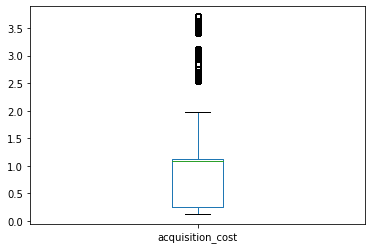

In [50]:
# исключаем из расчета органических пользователей
profiles_non_org = profiles.query('channel != "organic"')

# выводим стат данные
display(profiles_non_org.groupby('user_id')['acquisition_cost'].mean().describe())

# строим диаграмму размаха
profiles_non_org.groupby('user_id')['acquisition_cost'].mean().plot(kind='box')
plt.show()

**ВЫВОДЫ ПО РАСЧЕТАМ И ГРАФИКУ:**

* Значения CAC находятся в диапазоне от 0.13 до 3,72 долларов.

* 75% значений сосредоточены в интервале до 1,13 доллара. 

* Среднее равно: 1,13 доллара.

**Расчет среднего CAC на одного пользователя для каждого источника трафика:**

*органические пользователи исключаются из расчета*

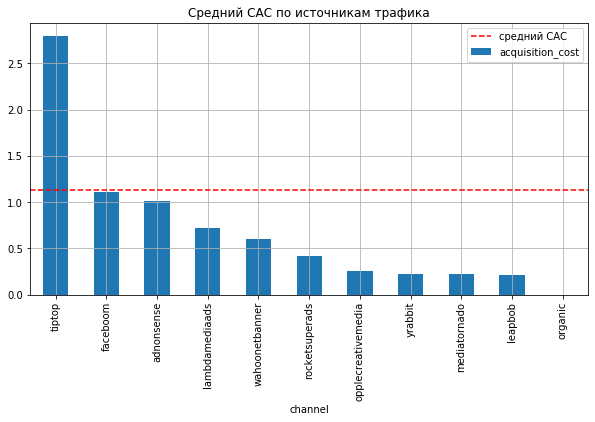

In [51]:
# строим график среднего CAC на одного пользователя для каждого источника трафика

profiles.groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False).plot(
    kind='bar', grid=True, title='Средний САС по источникам трафика', figsize=(10,5))
plt.axhline(y=1.13, color='red', linestyle='--', label='средний САС')
plt.legend()
plt.show()

**ВЫВОДЫ ПО ГРАФИКУ:**

Значения среднего CAC по каналам сильно разнятся:

* Минимальные значения у каналов leapbob, mediatornado, yrabbit = 0,21 цент

* Максимальное значение у канала tiptop = 2,8 доллара

* faceboom находится на уровне среднего = 1,3 доллара

* Все каналы кроме faceboom и tiptop не достигают и не пересекают линии среднего

#### Выводы

* **Сколько денег потратили всего / на каждый источник / по времени** - **всего** за обозначенный период на продвижение было потрачено **105 497** денежных средств. 83% из них пришлись на 2 канала, работающие в регионе США:

>tiptop	**54 751** / доля **0.52** / регион **США**
>
>faceboom	**32 445**	/ доля **0.31** / регион **США**
>
>wahoonetbanner	**5 151**	/ доля **0.05** / регион **Европа**
>
>adnonsense	**3 911**	/ доля **0.04** / регион **Европа**
>
>opplecreativemedia	**2 151**	/ доля **0.02** / регион **Европа**
>
>rocketsuperads	**1 833**	/ доля **0.02** / регион **США**
>
>leapbob	**1 797**	/ доля **0.02** / регион **Европа**
>
>lambdamediaads	**1 557**	/ доля **0.01** / регион **Европа**
>
>mediatornado	**954**	/ доля **0.01** / регион **США**
>
>yrabbit	**944**	/ доля **0.01** / регион **США**

Динамика затрат имеет общий тренд роста с минимальным значением в начале мая и максимальным - в конце сентября.
По каналам основные инвестиции были сделаны в 2 канала, покрывающих регион США: tiptop (США) и faceboom (США). Среди "европейских" каналов можно выделить adnonsense и wahoonetbanner. Динамика tiptop (США) и faceboom (США) имеет постоянный тренд роста. Остальные каналы ивестировались на одном уровне во времени.

* **Сколько в среднем стоило привлечение одного пользователя из каждого источника** - в среднем привлечение одного пользователя за период стоило **1,13** денежных единиц. Однако по каналам цифры существенно разнятся:

>**2.8** tiptop / регион **США** / **20%** привлеченных в регионе / **27%** платящих
>
>**1.1** faceboom / регион **США** / **29%** привлеченных в регионе / **52%** платящих
>
>**1.0** adnonsense / регион **Европа** / **8%** привлеченных в регионе / **22%** платящих
>
>**0.7** lambdamediaads / регион **Европа** / **4%** привлеченных в регионе / **11%** платящих
>
>**0.6** wahoonetbanner / регион **Европа** / **17%** привлеченных в регионе / **23%** платящих
>
>**0.4** rocketsuperads / регион **США** / **4%** привлеченных в регионе / **5%** платящих
>
>**0.2** opplecreativemedia / регион **Европа** / **17%** привлеченных в регионе / **12%** платящих
>
>**0.2** yrabbit / регион **США** / **4%** привлеченных в регионе / **2%** платящих
>
>**0.2** mediatornado / регион **США** / **4%** привлеченных в регионе / **2%** платящих
>
>**0.2** leapbob / регион **Европа** / **17%** привлеченных в регионе / **13%** платящих



## Функции для расчета и анализа LTV, ROI, удержания и конверсии

### функции RETENTION

In [52]:
# строим функцию для расчета retention

def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
    # решаем какие столбцы оставим для группировки удержания, столбец признака платящего пользователя остается всегда
    dimensions = ['payer'] + dimensions
    
    # оттсекаем всех пользователей, которые не могли "дожить" до нужного горизонта 
    # (присоединились позже чем observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # формируем массив сырых данных
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # функция группировки по нужному набору измерений
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')      
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) 
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   
        result = result.div(result['cohort_size'], axis = 0)                                                     
        result = result[['cohort_size'] + list(range(horizon_days))]                                             
        result['cohort_size'] = cohort_sizes                                                                     
        return result
    
    # расчитываем удержание 
    retention = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # рассчитываем удержание по всем параметрам + дата
    retention_hist = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # возвращаем и таблицы удержания и сырые данные
    return result_raw, retention, retention_hist

### функции CONVERSION

In [53]:
# строим функцию для расчета conversion

def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # получаем пользовательские профили и данные о покупках
    # передаём их в качестве аргументов profiles и orders

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # находим дату и время первой покупки для каждого пользователя
    first_purchases = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # строим функцию для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):

        # строим таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )

        # рассчитываем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)

        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        # объединяем таблицы размеров когорт и конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)

        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    conversion = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики конверсии
    conversion_hist = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, conversion, conversion_hist

### функции LTV и ROI

In [54]:
def get_ltv_roi(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    ltv, roi_gr = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    ltv_hist, roi_hist = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  
        ltv,  
        ltv_hist,  
        roi_gr,  
        roi_hist,  
    )

## Оценка окупаемости рекламы для привлечения пользователей

### Анализ общей окупаемости рекламы

#### расчет LTV

In [55]:
# делаем срез профилей для исключения органических клиентов из группы анализа окупаемости рекламы

profiles_non_org = profiles.query('channel != "organic"')

In [56]:
# рассчитываем ltv для неорганических клиентов,
# момент анализа 01.11.2019
# горизонт анализа 14 дней

result_raw, ltv, ltv_hist, roi, roi_hist = get_ltv_roi(
    profiles_non_org,
    orders,
    datetime(2019,11,1).date(),
    14,
    dimensions=[],
    ignore_horizon=False,
)
display(ltv)

cohort_size       0.0       1.0       2.0      3.0       4.0  \
cohort                                                                    
All users        88644  0.345512  0.435754  0.504507  0.56109  0.611436   

                5.0       6.0       7.0       8.0       9.0      10.0  \
cohort                                                                  
All users  0.654368  0.694084  0.729778  0.764619  0.796665  0.826152   

              11.0      12.0     13.0  
cohort                                 
All users  0.85207  0.878116  0.90203

In [57]:
# производим проверку - сумма размеров когорт неорганических клиентов равна
# числу новых неорганических клиентов в изучаемый период

# в профилях находим пользователей, привелеченных с 01.05.2019 по 19.10.2019,
# складываем размеры когорт

report=profiles_non_org.query('datetime(2019,5,1).date() <=dt <= datetime(2019,10,19).date()')
print('Общее кол-во новых неорганических пользователей:{} {}'.
      format(len(report['user_id'].unique()), ltv['cohort_size'].sum()))

Общее кол-во новых неорганических пользователей:88644 88644


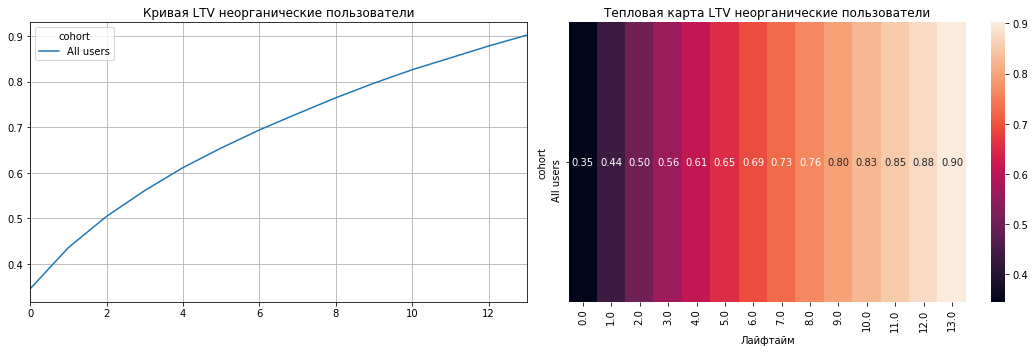

In [58]:
# производим проверку,
# строим кривую ltv и тепловую карту неорганических пользователей

plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 2, 1)
ltv.drop(columns=['cohort_size']).T.plot(grid=True, ax=ax1)
plt.title('Кривая LTV неорганические пользователи')

ax2 = plt.subplot(1, 2, 2)
sns.heatmap(ltv.drop(columns=['cohort_size']), annot=True, fmt='.2f', ax=ax2)
plt.title('Тепловая карта LTV неорганические пользователи')
plt.xlabel('Лайфтайм')

plt.tight_layout()
plt.show()

**ВЫВОДЫ ПО ГРАФИКАМ:**

Кривая LTV неорганических пользователей плавно растет ожидаемым образом от 0,35 центов средней накопительной выручки на первой неделе до 0,90 центов на 14 неделе.

In [59]:
# рассчитываем ltv для неорганических клиентов по странам,
# момент анализа 01.11.2019
# горизонт анализа 14 дней

result_raw_reg, ltv_reg, ltv_hist_reg, roi_reg, roi_hist_reg = get_ltv_roi(
    profiles_non_org,
    orders,
    datetime(2019,11,1).date(),
    14,
    dimensions=['region'],
    ignore_horizon=False,
)
display(ltv_reg)

cohort_size       0.0       1.0       2.0       3.0       4.0  \
region                                                                         
france               10516  0.193428  0.259783  0.311696  0.360199  0.406892   
germany               9030  0.186350  0.258858  0.327945  0.375473  0.422776   
uk                   10536  0.218683  0.296762  0.367626  0.416607  0.465505   
united states        58562  0.420183  0.519636  0.590981  0.651779  0.703511   

                    5.0       6.0       7.0       8.0       9.0      10.0  \
region                                                                      
france         0.450173  0.481019  0.507213  0.541484  0.570906  0.600042   
germany        0.460907  0.496938  0.534074  0.571104  0.605367  0.641507   
uk             0.503964  0.556090  0.585644  0.623741  0.645527  0.668830   
united states  0.747926  0.787570  0.825852  0.859873  0.893893  0.923530   

                   11.0      12.0      13.0  
region                                       
france         0.621870  0.649871  0.670278  
germany        0.665932  0.691355  0.713019  
uk             0.692322  0.719800  0.743481  
united states  0.950849  0.976382  1.001316

#### расчет CAC и ROI

In [60]:
# рассчитываем roi для неорганических пользователей
result_raw, ltv, ltv_hist, roi, roi_hist = get_ltv_roi(
    profiles_non_org,
    orders,
    datetime(2019,11,1).date(),
    14,
    dimensions=[],
    ignore_horizon=False,
)
display(roi)

cohort_size       cac       0.0       1.0       2.0       3.0  \
cohort                                                                     
All users        88644  1.117794  0.309102  0.389834  0.451341  0.501962   

                4.0      5.0       6.0       7.0       8.0       9.0  \
cohort                                                                 
All users  0.547002  0.58541  0.620941  0.652873  0.684043  0.712711   

               10.0      11.0      12.0      13.0  
cohort                                             
All users  0.739091  0.762278  0.785579  0.806974

In [61]:
# производим проверку cac,
# сравниваем расходы на привлечение в таблице roi и траты на рекламу 

print(
    'Общие расходы на привлечение из таблицы ROI:{:.2f}'.format(
        roi.loc['All users', 'cac'] * roi.loc['All users', 'cohort_size']))
print(
'Общие расходы на привлечение из таблицы costs:{:.2f}'.format(
costs.query('dt <= datetime(2019,10,19).date()')['costs'].sum()))

Общие расходы на привлечение из таблицы ROI:99085.74
Общие расходы на привлечение из таблицы costs:99085.74


**ВЫВОДЫ ПО РАСЧЕТАМ:**

Расчеты совпадают. Принимаем, что CAC посчитан верно.

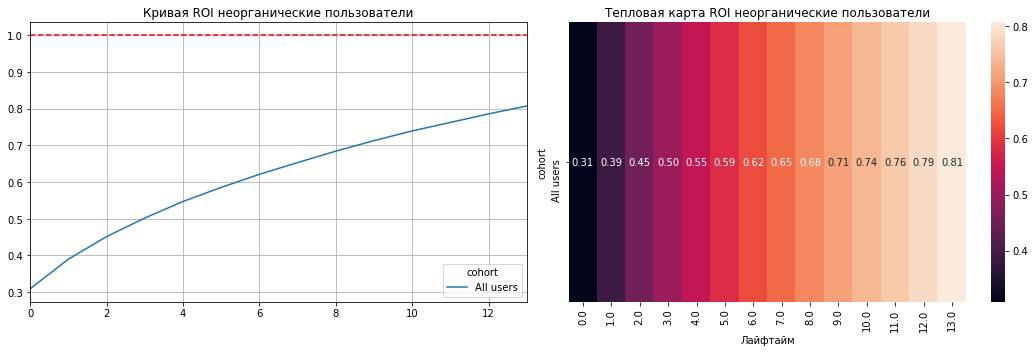

In [62]:
# строим кривую roi и тепловыую карту неорганических пользователей

plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 2, 1)
roi.drop(columns=['cohort_size', 'cac']).T.plot(grid=True, ax=ax1)
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.title('Кривая ROI неорганические пользователи')

ax2 = plt.subplot(1, 2, 2)
sns.heatmap(roi.drop(columns=['cohort_size', 'cac']), annot=True, fmt='.2f', ax=ax2)
plt.title('Тепловая карта ROI неорганические пользователи')
plt.xlabel('Лайфтайм')

plt.tight_layout()
plt.show()

**ВЫВОДЫ ПО ГРАФИКУ:**

Кривая ROI неизменно растет, но при этом не пересекает 1, что свидетельствует о невозврате инвистиций в маркетинг в общем по проекту.

#### графики динамики LTV, CAC, ROI

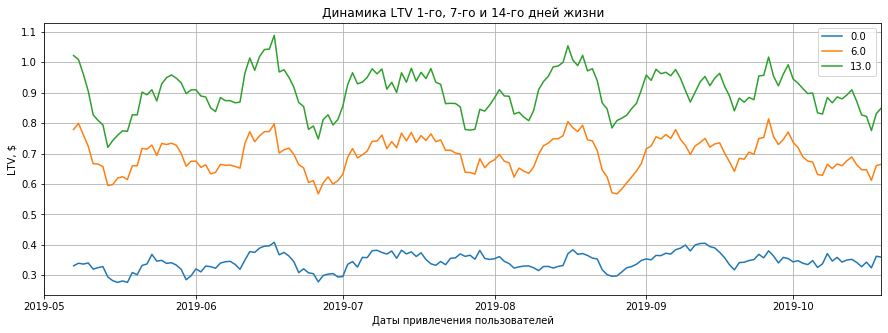

In [63]:
# строим график истории изменений LTV 1-го, 7-го и 14-го дней жизни
# применяем скользящее среднее для выравнивания с окном 7

report = ltv_hist[[0, 6, 13]]
report.rolling(window=7).mean().plot(grid=True, figsize=(15, 5))
plt.title('Динамика LTV 1-го, 7-го и 14-го дней жизни')
plt.ylabel('LTV, $')
plt.xlabel('Даты привлечения пользователей')
plt.show()


**ВЫВОДЫ ПО ГРАФИКУ:**

* Динамика LTV 1-го, 7-го и 14-го дней жизни синхронизирована и имеет повторяющиеся паттерны.

* Динамика 1-го дня колеблется в диапазоне 30 - 40 центов.

* Динамика 7-го дня колеблется в диапазоне 60 - 80 центов.

* Динамика 14-го дня колеблется в диапазоне 80 - 1.05.

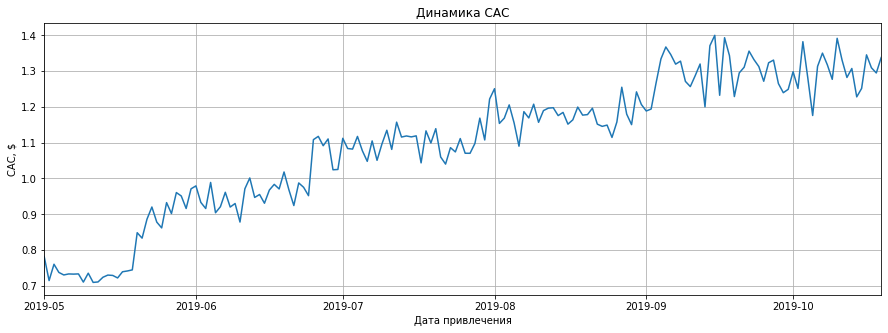

In [64]:
# строим график истории изменений CAC

roi_hist.groupby('dt')['cac'].mean().plot(grid=True, figsize=(15, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС')
plt.show()

**ВЫВОДЫ ПО ГРАФИКУ:**

Динамика CAC имеет общий тренд роста в изучаемый период от 70 центов в начале проекта до 1.40 в конце.

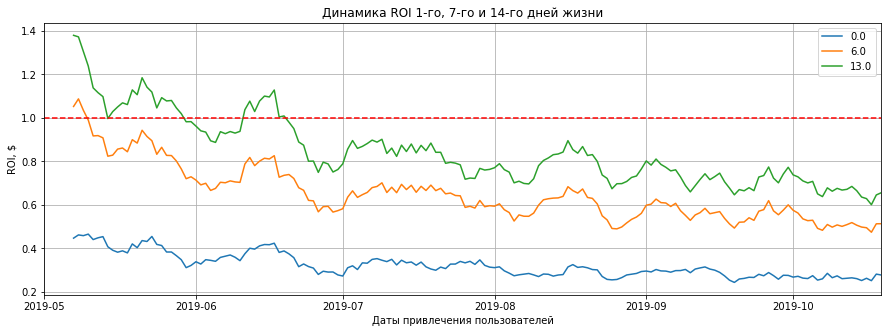

In [65]:
# строим график истории изменения ROI 1-го, 7-го и 14-го дней жизни
# применяем скользящее среднее для выравнивания с окном 7

roi_hist[[0, 6, 13]].rolling(window=7).mean().plot(grid=True, figsize=(15, 5))
plt.title('Динамика ROI 1-го, 7-го и 14-го дней жизни')
plt.ylabel('ROI, $')
plt.xlabel('Даты привлечения пользователей')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.show()

**ВЫВОДЫ ПО ГРАФИКУ:**

* Динамика ROI 1-го, 7-го и 14-го дней жизни показывает общий тренд на снижение.

* Когорты, привлеченные на начальном этапе проекта в период с мая по середину июня показывали ROI 14-го дня выше уровня окупаемости.

* Когорты, привлеченные с середины июня до конца проекта были ниже уровня окупаемости на протяжении всего жизненного цикла.

### Анализ окупаемости рекламы с разбивкой по устройствам

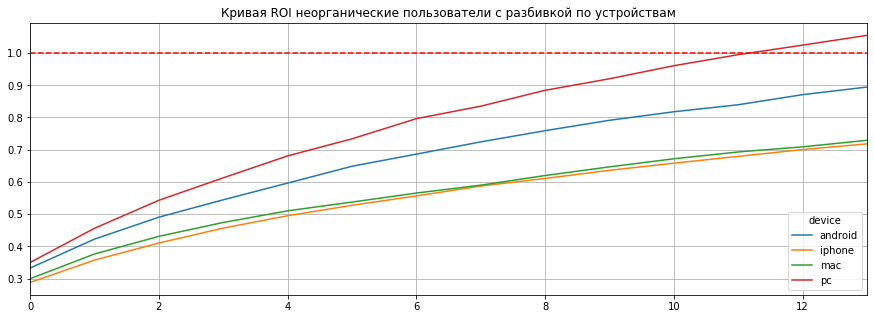

In [66]:
# строим кривую roi и динамику изменений с разбивкой по устройствам

result_raw_dev, ltv_dev, ltv_hist_dev, roi_dev, roi_hist_dev = get_ltv_roi(
    profiles_non_org,
    orders,
    datetime(2019,11,1).date(),
    14,
    dimensions=['device'],
    ignore_horizon=False,
)

roi_dev.drop(columns=['cohort_size', 'cac']).T.plot(grid=True, figsize=(15, 5))
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.title('Кривая ROI неорганические пользователи с разбивкой по устройствам')

plt.show()

**ВЫВОДЫ ПО ГРАФИКУ:**

* Единственное устройство, пользователи которого пересекали уровень окупаемости маркетинговых инвестиций, это pc. При этом пользователи pc составляют 20% от общего числа пользователей и 17% от платящих пользователей.

* Средний результат показали пользователи android.

* Хуже всего с точки зрения окупаемости выступили пользователи iphone и mac.

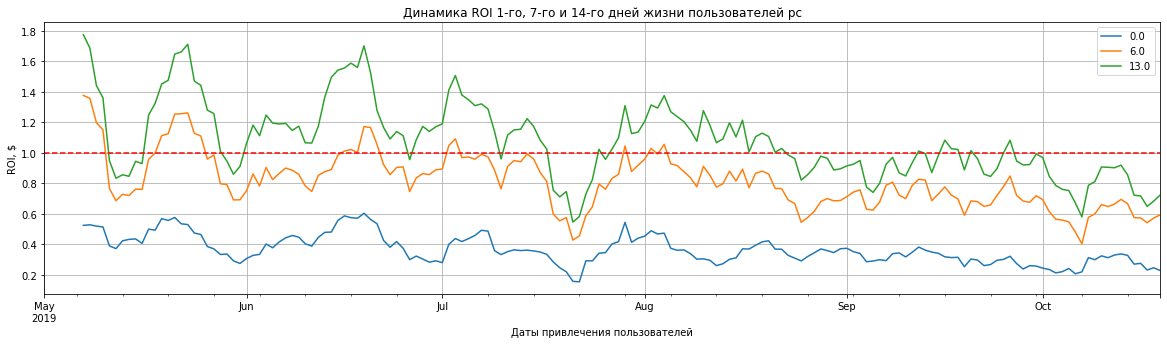

In [67]:
# строим график истории изменения ROI 1-го, 7-го и 14-го дней жизни пользователей pc
# применяем скользящее среднее для выравнивания с окном 7

roi_hist_dev.query('device == "pc"')[[0, 6, 13]].rolling(window=7).mean().reset_index().set_index('dt').plot(
    grid=True, figsize=(20, 5))

plt.title('Динамика ROI 1-го, 7-го и 14-го дней жизни пользователей рс')
plt.ylabel('ROI, $')
plt.xlabel('Даты привлечения пользователей')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.show()

**ВЫВОДЫ ПО ГРАФИКУ:**

* Динамика ROI 1, 7-го и 14-го дня пользователей рс показывает, что когорты, привлеченные с мая по середину июля, имели положительную окупаемость маркетинговых инвестиций к концу второй недели.

* В конце июля произошел провал, который обозначил тренд на снижение ниже уровня окупаемости к концу проекта.

### Анализ окупаемости рекламы с разбивкой по странам

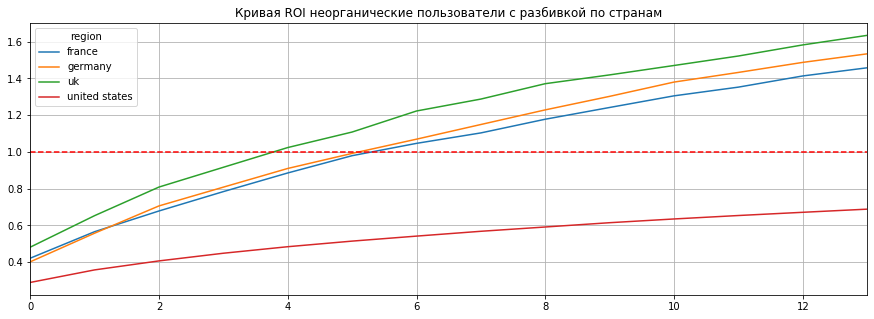

In [68]:
# строим кривую roi и динамику изменений с разбивкой по странам

result_raw_reg, ltv_reg, ltv_hist_reg, roi_reg, roi_hist_reg = get_ltv_roi(
    profiles_non_org,
    orders,
    datetime(2019,11,1).date(),
    14,
    dimensions=['region'],
    ignore_horizon=False,
)

roi_reg.drop(columns=['cohort_size', 'cac']).T.plot(grid=True, figsize=(15, 5))
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.title('Кривая ROI неорганические пользователи с разбивкой по странам')

plt.show()

**ВЫВОДЫ ПО ГРАФИКУ:**

* Кривые ROI по регионам показывают, что единственным регионом, не преодолевшим уровень окупаемости является США, где сосредоточено 67% всех пользователей и 78% платящих пользователей, но при этом и доля маркетинговых инвестиций составляет 87% от общего.

* Регионы Великобритания, Германия и Франция преодолевали порого окупаемости на 4-5 неделе.

* Лучший результат показала Великобритания с общей долей пользователей 12% и 8% среди платящих.

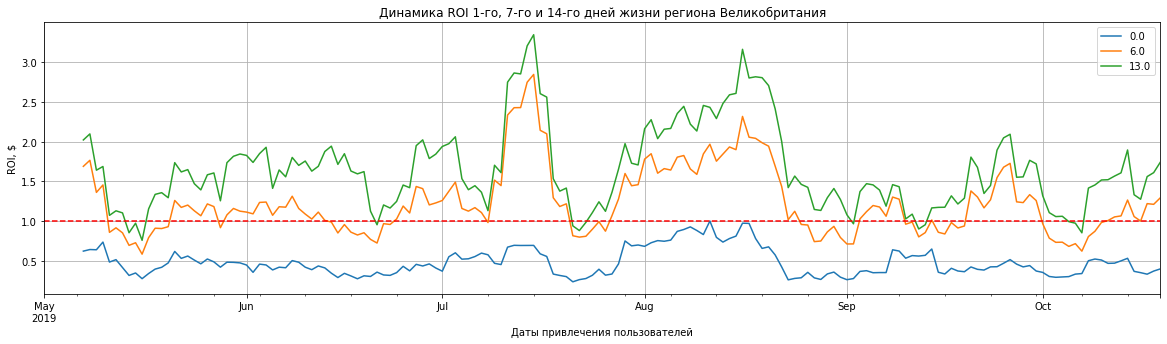

In [69]:
# строим график истории изменения ROI 1-го, 7-го и 14-го дней жизни региона Великобритания
# применяем скользящее среднее для выравнивания с окном 7

roi_hist_reg.query('region == "uk"')[[0, 6, 13]].rolling(window=7).mean().reset_index().set_index('dt').plot(
    grid=True, figsize=(20, 5))

plt.title('Динамика ROI 1-го, 7-го и 14-го дней жизни региона Великобритания')
plt.ylabel('ROI, $')
plt.xlabel('Даты привлечения пользователей')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.show()

**ВЫВОДЫ ПО ГРАФИКУ:**

Динамика ROI 1, 7-го и 14-го дней жизни региона Великобритания показывает, что уровень окупаемости в регионе достигался уже к 7-му дню, а к 14-му практически не опускался ниже этого уровня.

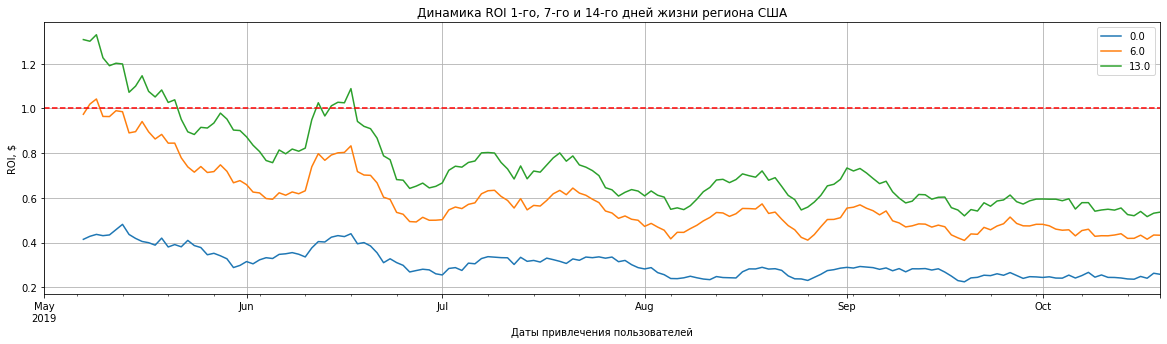

In [70]:
# строим график истории изменения ROI 1-го, 7-го и 14-го дней жизни региона США
# применяем скользящее среднее для выравнивания с окном 7

roi_hist_reg.query('region == "united states"')[[0, 6, 13]].rolling(window=7).mean().reset_index().set_index('dt').plot(
    grid=True, figsize=(20, 5))

plt.title('Динамика ROI 1-го, 7-го и 14-го дней жизни региона США')
plt.ylabel('ROI, $')
plt.xlabel('Даты привлечения пользователей')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.show()

**ВЫВОДЫ ПО ГРАФИКУ:**

* Динамика ROI 1, 7-го, 14-го дней показывает устойчивый тренд на снижение.

* Когорты, привлеченные в начале проекта (первые 3 недели мая) на 14-й день показывали результат выше уровня окупаемости.

* В начале июня произошел провал со всплеском к середине июня.

* До конца августа результат плавно ухудшался.

* С середины сентября можно сказать, что метрика выравнялась на отрицательном значении 14-го дня 0,5 - 0,6.

### Анализ окупаемости рекламы с разбивкой по рекламным каналам

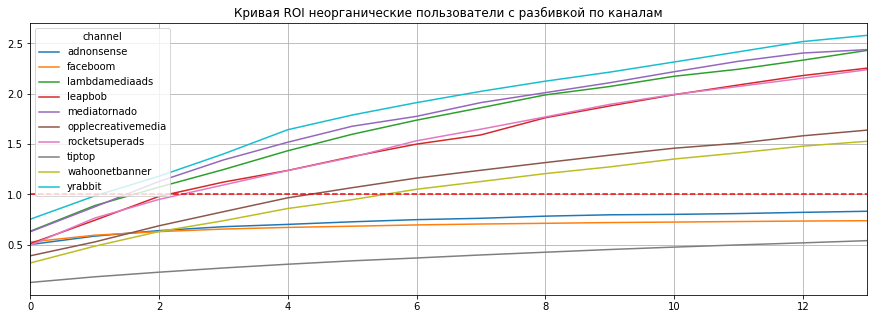

In [71]:
# строим кривую roi и динамику изменений с разбивкой по каналам

result_raw_chan, ltv_chan, ltv_hist_chan, roi_chan, roi_hist_chan = get_ltv_roi(
    profiles_non_org,
    orders,
    datetime(2019,11,1).date(),
    14,
    dimensions=['channel'],
    ignore_horizon=False,
)

roi_chan.drop(columns=['cohort_size', 'cac']).T.plot(grid=True, figsize=(15, 5))
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.title('Кривая ROI неорганические пользователи с разбивкой по каналам')

plt.show()

**ВЫВОДЫ ПО ГРАФИКУ:**

* Кривые ROI по каналам показывают, что из 10 каналов 3 так и недостигли уровня окупаемости: tiptop (доля инвестиций 52% / регион США), faceboom (доля инвестиций 31% / регион США), adnonsense (доля инвестиций 4% / регион Европа).

* Лучше всего с точки зрения окупаемости показали себя yrabbit, mediatornado и lambdamediaads, достигавшие порога окупаемости на 1 - 2 неделе.

* На втором месте идут rocketsuperads и leapbob, достигавшие порога окупаемости на 3 - 4 неделе.

* На третьем - opplecreativemedia и wahoonetbanner, достигавшие порога окупаемости на 5 - 6 неделе.

### Графики конверсии  с разбивкой по устройствам, странам, каналам

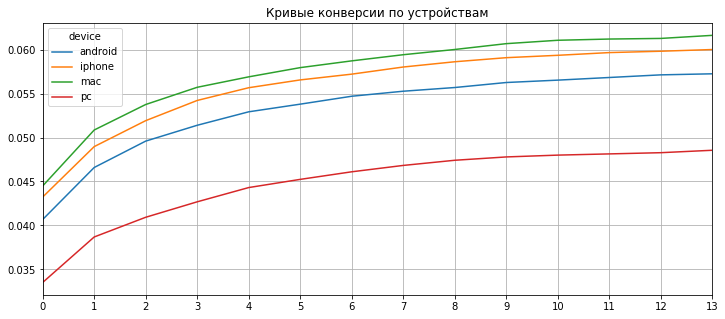

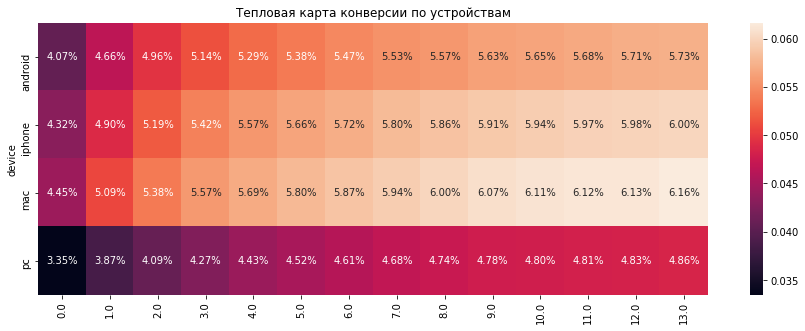

In [72]:
# получаем сырые данные, таблицу конверсии и таблицу динамики конверсии с разбивкой по устройствам
conversion_raw, conversion, conversion_hist = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)

# строим хитмэп и кривые конверсии
# исключаем размеры когорт
report = conversion.drop(columns = ['cohort_size'])

report.T.plot(grid=True, xticks=list(report.columns.values), figsize=(12,5))
plt.title('Кривые конверсии по устройствам')
plt.show()

sns.heatmap(report, annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии по устройствам')
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

**ВЫВОДЫ ПО ГРАФИКАМ:**

* Кривые конверсии по устройствам плавно растут в направлении единицы и не пересекают её.

* Выше всего конверсия у владельцев **mac**: более 4,45% новых пользователей совершают покупки в день первого посещения, а к 14-му дню "жизни" доля покупателей достигает 6,16%.

* Хуже всего конвертируются владельцы **pc**: конверсия первого дня составляет 3,35%, к 14-му дню конверсия достигает 4,86%

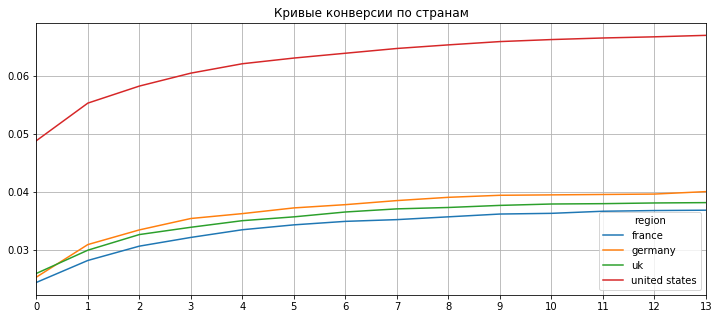

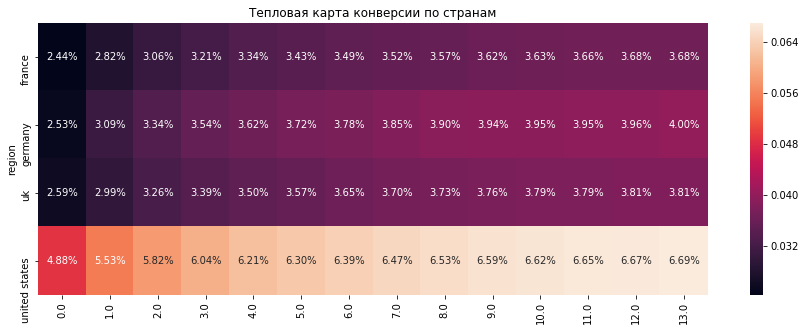

In [73]:
# получаем сырые данные, таблицу конверсии и таблицу динамики конверсии с разбивкой по странам
conversion_raw, conversion, conversion_hist = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region']
)

# строим хитмэп и кривые конверсии
# исключаем размеры когорт
report = conversion.drop(columns = ['cohort_size'])

report.T.plot(grid=True, xticks=list(report.columns.values), figsize=(12,5))
plt.title('Кривые конверсии по странам')
plt.show()

sns.heatmap(report, annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии по странам')
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

**ВЫВОДЫ ПО ГРАФИКАМ:**

* Кривые конверсии по странам плавно растут в направлении единицы и не пересекают её.

* Выше всего конверсия у пользователей из **США**: более 4,88% новых пользователей совершают покупки в день первого посещения, а к 14-му дню "жизни" доля покупателей достигает 6,69%.

* Разрыв между первым и вторым местом составляет порядка 2%. На втором месте после США идет **Германия** с конверсией первого дня - 2,53% и 14-го дня - 4%.

* Хуже всего конвертируются пользователи из **Франции**: конверсия первого дня составляет 2,44%, к 14-му дню конверсия достигает 3,68%

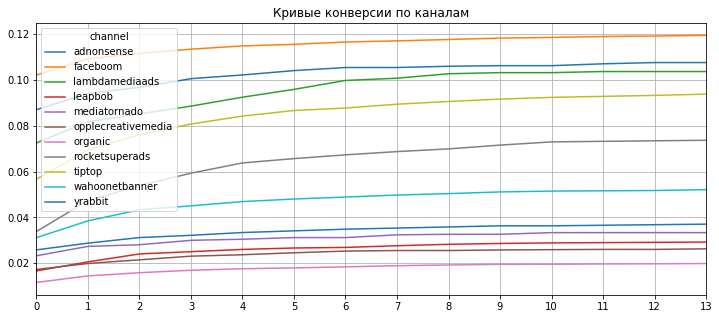

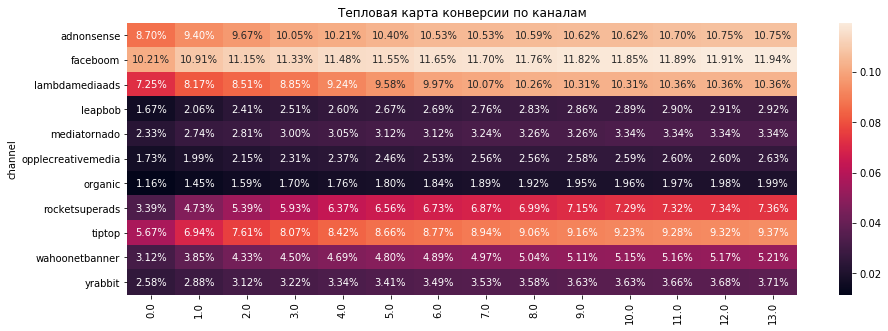

In [74]:
# получаем сырые данные, таблицу конверсии и таблицу динамики конверсии с разбивкой по каналам
conversion_raw, conversion, conversion_hist = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)

# строим хитмэп и кривые конверсии
# исключаем размеры когорт
report = conversion.drop(columns = ['cohort_size'])

report.T.plot(grid=True, xticks=list(report.columns.values), figsize=(12,5))
plt.title('Кривые конверсии по каналам')
plt.show()

sns.heatmap(report, annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии по каналам')
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

**ВЫВОДЫ ПО ГРАФИКАМ:**

* Кривые конверсии по каналам плавно растут в направлении единицы и не пересекают её.

* Все каналы можно разбить на 3 условных группы:

> **10 - 12%**, куда вошли:
>
> **faceboom** - 10,21% новых пользователей совершают покупки в день первого посещения, а к 14-му дню "жизни" доля покупателей достигает 11,94%
>
> **adnonsense** - 8,7% новых пользователей совершают покупки в день первого посещения, а к 14-му дню "жизни" доля покупателей достигает 10,75%
>
> **lambdamediaads** - 7,25% новых пользователей совершают покупки в день первого посещения, а к 14-му дню "жизни" доля покупателей достигает 10,36%
>
> **5 - 9%**, куда вошли:
>
> **tiptop** - 5,67% / 9,37%
>
> **rocketsuperads** - 3,39% / 7,36%
>
> **wahoonetbanner** - 3,12% / 5,21%
>
> **2 - 4%**, куда вошли:
>
> **yrabbi**t - 2,58% / 3,71%
>
> **mediatornado** - 2,33% / 3,34%
>
> **leapbob** - 1,67% - 2,92%
>
> **opplecreativemedia** - 1,73% / 2,63%

* Хуже всего конвертируются **органические** пользователи: 1,16% новых пользователей совершают покупки в день первого посещения, а к 14-му дню "жизни" доля покупателей достигает 1,99%.


### Графики удержания  с разбивкой по каналам, странам, устройствам

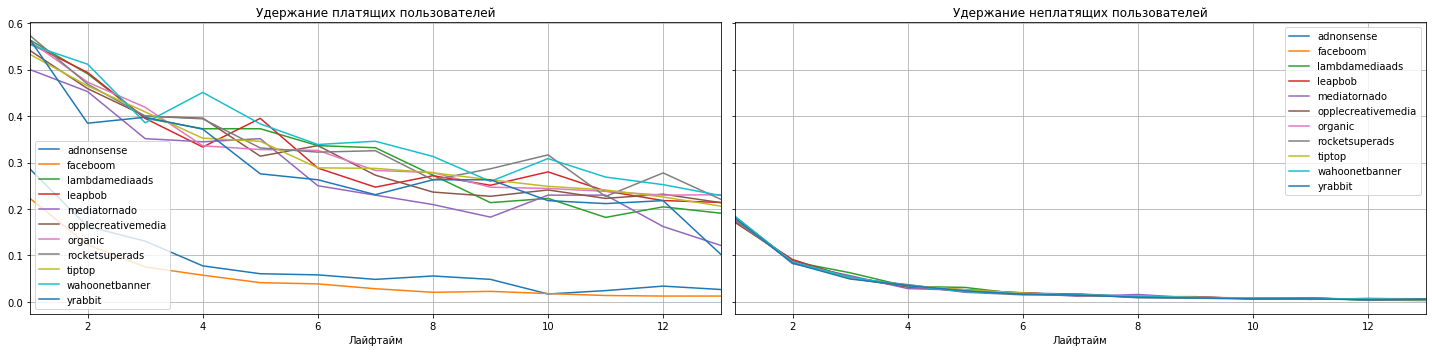

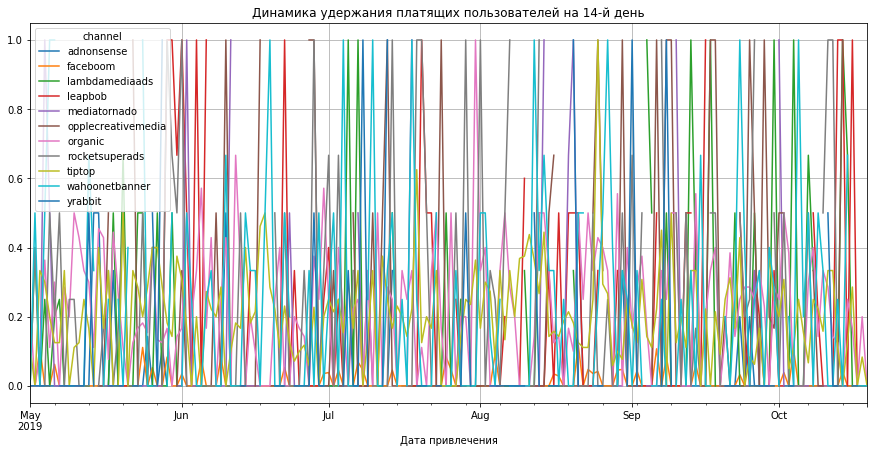

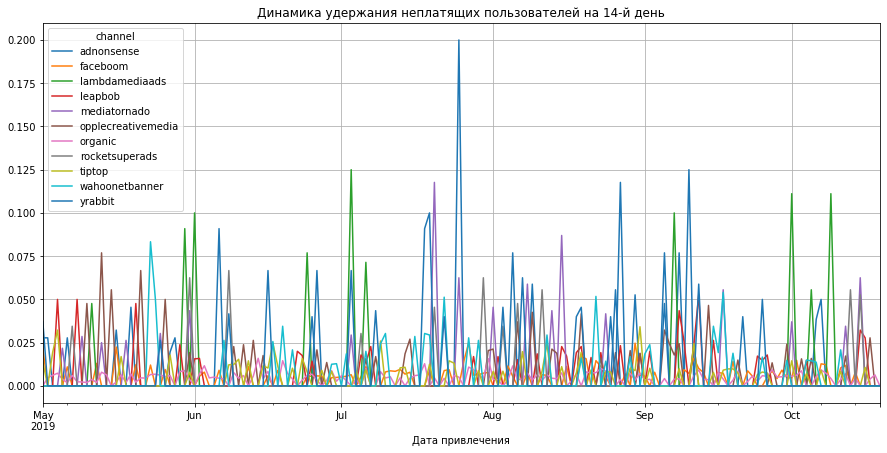

In [75]:
# получаем сырые данные, таблицу удержания и таблицу динамики удержания с разбивкой по каналам
result_raw_chan, retention_chan, retention_hist_chan = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions = ['channel'], ignore_horizon = False)

# задаём размер сетки для графиков
plt.figure(figsize=(20, 5))

# исключаем размеры когорт и удержания первого дня
retention_chan = retention_chan.drop(columns=['cohort_size', 0])

# если в индексах таблицы удержания только payer,
# добавляем второй признак — cohort
if retention_chan.index.nlevels == 1:
    retention_chan['cohort'] = 'All users'
    retention_chan = retention_chan.reset_index().set_index(['cohort', 'payer'])

# строим кривые удержания платящих пользователей
ax1 = plt.subplot(1, 2, 1)
retention_chan.query('payer == True').droplevel('payer').T.plot(grid=True, ax=ax1)
plt.legend()
plt.xlabel('Лайфтайм')
plt.title('Удержание платящих пользователей')

# строим кривые удержания неплатящих
ax2 = plt.subplot(1, 2, 2, sharey = ax1)
retention_chan.query('payer == False').droplevel('payer').T.plot(grid=True, ax=ax2)
plt.legend()
plt.xlabel('Лайфтайм')
plt.title('Удержание неплатящих пользователей')

plt.tight_layout()
plt.show()

# строим график динамики удержания платящих
# получаем названия столбцов для сводной таблицы
columns = [
    name
    for name in retention_hist_chan.index.names
    if name not in ['dt', 'payer']
    ]
# фильтруем данные, строим сводную таблицу и график по ней
retention_hist_chan.query('payer == True').pivot_table(index='dt', columns=columns, values=14-1, aggfunc='mean').plot(
    grid=True, figsize=(15,7))

plt.xlabel('Дата привлечения')
plt.title('Динамика удержания платящих пользователей на {}-й день'.format(14))
plt.show()
    
# строим график динамики удержания неплатящих
# фильтруем данные, строим сводную таблицу и график по ней
retention_hist_chan.query('payer == False').pivot_table(index='dt', columns=columns, values=14 - 1, aggfunc='mean').plot(
    grid=True, figsize=(15,7))

plt.xlabel('Дата привлечения')
plt.title('Динамика удержания неплатящих пользователей на {}-й день'.format(14))
plt.show()


**ВЫВОДЫ ПО ГРАФИКАМ:**

* Удержание убывает по экспоненциальному закону.

* Удержание неплатящих пользователей ниже и убывает быстрее, чем удержание платящих.

* По удержанию платящих пользователей каналы можно разбить на 2 условные группы:

> Хуже всего показали результаты по удержанию каналы faceboom (США) и adnonsense (Европа). faceboom стартует с 23% в первый день / adnonsense с 30% и далее кривые стремятся к 0.
>
> Остальные каналы показывают похожую динамику - стартуют в диапазоне 50 - 58% удержание первого дня и к 14-му дню убывают к диапазону 10 - 25%.

* Показатели удержания неплатящих пользователей у весх каналов приблизительно одинаковые - стартуют с 18%, к 8-му дню приближаются к 0, с 9-го дня и далее бесконечно стремятс к 0.

*  Лучшую динамику удержания платящих пользователей на 14-й день показывают каналы: leapbob, wahoonetbanner, lambdamediaads, oppelcreativemedia. Многократно когорты показывают 100%. Также в эту группу попадают органические пользователи.

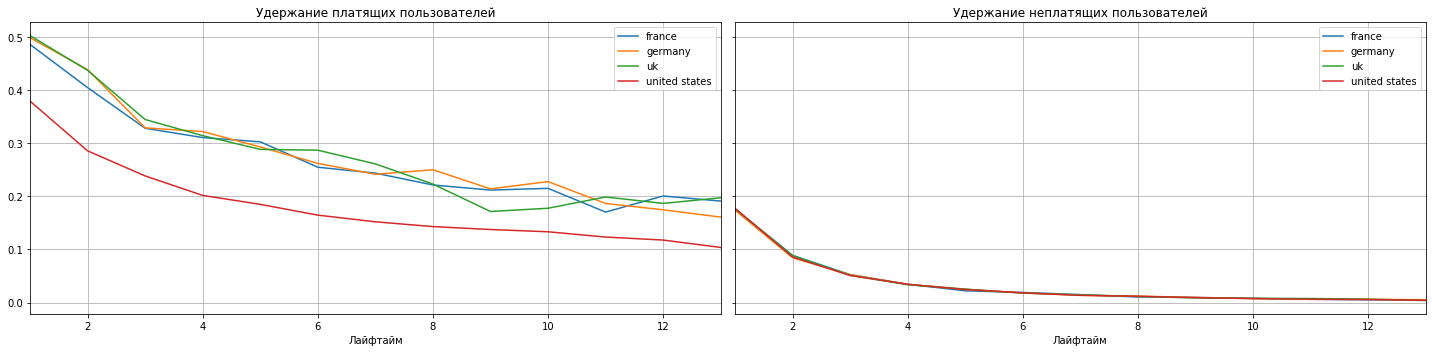

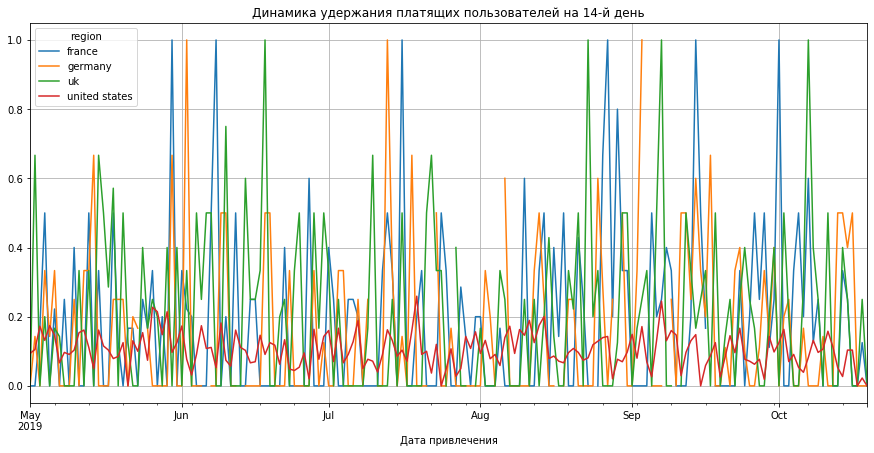

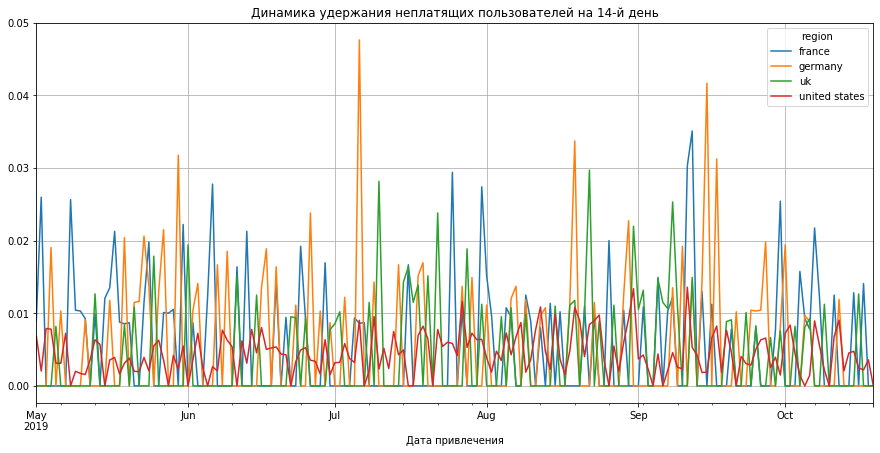

In [76]:
# получаем сырые данные, таблицу удержания и таблицу динамики удержания с разбивкой по странам
result_raw_reg, retention_reg, retention_hist_reg = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions = ['region'], ignore_horizon = False)

# задаём размер сетки для графиков
plt.figure(figsize=(20, 5))

# исключаем размеры когорт и удержания первого дня
retention_reg = retention_reg.drop(columns=['cohort_size', 0])

# если в индексах таблицы удержания только payer,
# добавляем второй признак — cohort
if retention_reg.index.nlevels == 1:
    retention_reg['cohort'] = 'All users'
    retention_reg = retention_reg.reset_index().set_index(['cohort', 'payer'])

# строим кривые удержания платящих пользователей
ax1 = plt.subplot(1, 2, 1)
retention_reg.query('payer == True').droplevel('payer').T.plot(grid=True, ax=ax1)
plt.legend()
plt.xlabel('Лайфтайм')
plt.title('Удержание платящих пользователей')

# строим кривые удержания неплатящих
ax2 = plt.subplot(1, 2, 2, sharey = ax1)
retention_reg.query('payer == False').droplevel('payer').T.plot(grid=True, ax=ax2)
plt.legend()
plt.xlabel('Лайфтайм')
plt.title('Удержание неплатящих пользователей')

plt.tight_layout()
plt.show()

# строим график динамики удержания платящих
# получаем названия столбцов для сводной таблицы
columns = [
    name
    for name in retention_hist_reg.index.names
    if name not in ['dt', 'payer']
    ]
# фильтруем данные, строим сводную таблицу и график по ней
retention_hist_reg.query('payer == True').pivot_table(index='dt', columns=columns, values=14-1, aggfunc='mean').plot(
    grid=True, figsize=(15,7))

plt.xlabel('Дата привлечения')
plt.title('Динамика удержания платящих пользователей на {}-й день'.format(14))
plt.show()
    
# строим график динамики удержания неплатящих
# фильтруем данные, строим сводную таблицу и график по ней
retention_hist_reg.query('payer == False').pivot_table(index='dt', columns=columns, values=14 - 1, aggfunc='mean').plot(
    grid=True, figsize=(15,7))

plt.xlabel('Дата привлечения')
plt.title('Динамика удержания неплатящих пользователей на {}-й день'.format(14))
plt.show()


In [77]:
# выводим таблицу удержания по странам

display(retention_reg)

1         2         3         4         5   \
payer region                                                            
False france         0.176169  0.088897  0.052638  0.034634  0.022318   
      germany        0.173939  0.084553  0.052709  0.034480  0.025183   
      uk             0.176375  0.088655  0.051461  0.033705  0.025419   
      united states  0.177528  0.085803  0.051089  0.034613  0.024646   
True  france         0.485669  0.404459  0.328025  0.310510  0.302548   
      germany        0.498288  0.438356  0.328767  0.321918  0.292808   
      uk             0.502276  0.437026  0.344461  0.314112  0.288316   
      united states  0.378989  0.285540  0.238357  0.201710  0.184914   

                           6         7         8         9         10  \
payer region                                                            
False france         0.019192  0.015129  0.010690  0.009690  0.008002   
      germany        0.018375  0.013836  0.012225  0.009810  0.007613   
      uk             0.017881  0.014579  0.011588  0.009034  0.008161   
      united states  0.018431  0.013707  0.012001  0.009458  0.007662   
True  france         0.254777  0.243631  0.221338  0.211783  0.214968   
      germany        0.261986  0.241438  0.250000  0.214041  0.227740   
      uk             0.286798  0.261002  0.223065  0.171472  0.177542   
      united states  0.164605  0.152084  0.143075  0.137578  0.133303   

                           11        12        13  
payer region                                       
False france         0.006189  0.005376  0.005376  
      germany        0.006955  0.006296  0.005490  
      uk             0.007788  0.006479  0.003925  
      united states  0.006407  0.005797  0.004407  
True  france         0.170382  0.200637  0.191083  
      germany        0.186644  0.174658  0.160959  
      uk             0.198786  0.186646  0.197269  
      united states  0.123378  0.117728  0.103833

**ВЫВОДЫ ПО ГРАФИКАМ:**

* Удержание убывает по экспоненциальному закону.

* Удержание неплатящих пользователей ниже и убывает быстрее, чем удержание платящих.

* По удержанию платящих худший результат показывают США - метрика стратует с 39% на первой неделе и снижается до 10% на 14-ой.

* Европейские страны показывают похожую динамику и более высокие результаты: 1-я неделя в районе 50% со снижением к 14-ой до 20%. При этом Франция стартует на 1% хуже, но выравнивается с группой к 14-ой неделе. Германия стартует одинаково с Англией, но к 14-ой неделе проваливается на 2%.

*  Динамика удержания платящих пользователей на 14-й день подтверждает общий тренд: хуже всего показатели США, где колебания происходят в диапазоне 0 - 20%, показатели Франции по 6 когортам достигают уровня 100%, Великобритании по 4-м, Франции по 3-м.

* Лучшую динамику удержания неплатящих пользователей на 14-й день показывает Германия с максимальным показателем 4,8% и 4-х кратным пересечением уровня 3%. На втором месте идет Франция, которая по 13 когортам смогла достичь уровня 2% и выше. Хуже всего проявила себя динамика США, которая колеблется в диапазоне 0 - 1%.

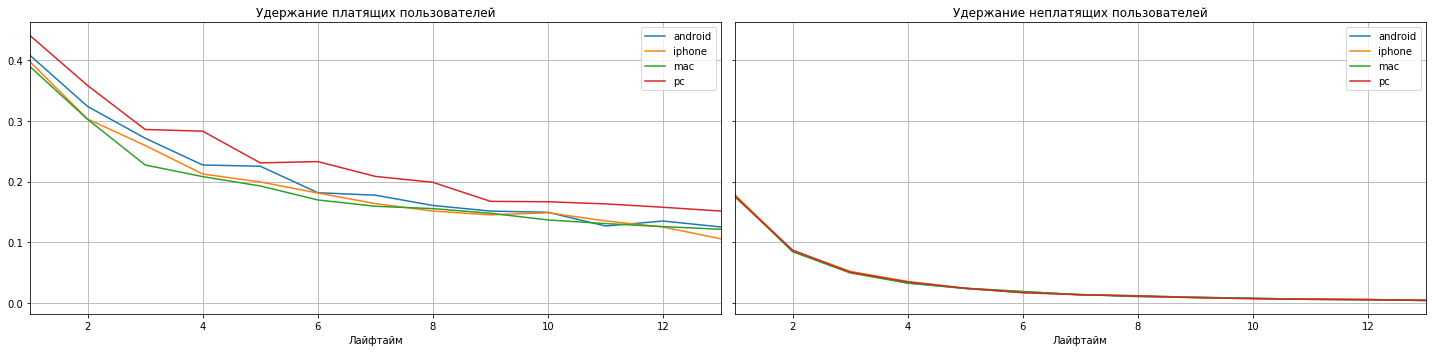

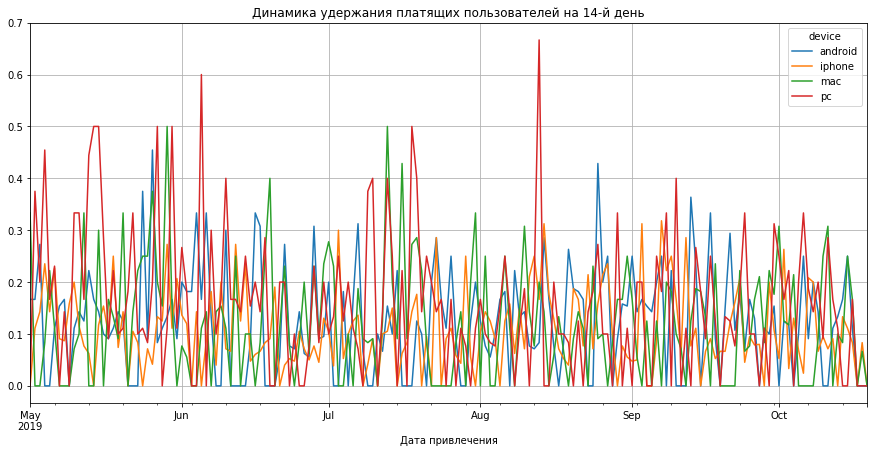

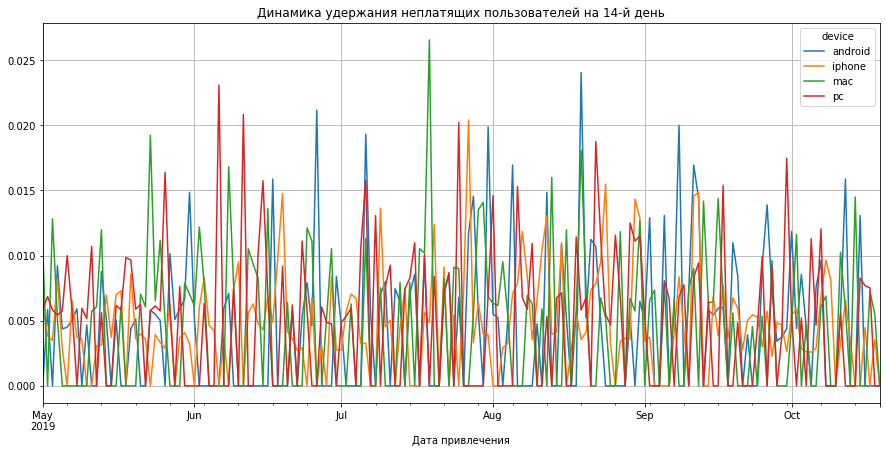

In [78]:
# получаем сырые данные, таблицу удержания и таблицу динамики удержания с разбивкой по устройствам
result_raw_dev, retention_dev, retention_hist_dev = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions = ['device'], ignore_horizon = False)

# задаём размер сетки для графиков
plt.figure(figsize=(20, 5))

# исключаем размеры когорт и удержания первого дня
retention_dev = retention_dev.drop(columns=['cohort_size', 0])

# если в индексах таблицы удержания только payer,
# добавляем второй признак — cohort
if retention_dev.index.nlevels == 1:
    retention_dev['cohort'] = 'All users'
    retention_dev = retention_dev.reset_index().set_index(['cohort', 'payer'])

# строим кривые удержания платящих пользователей
ax1 = plt.subplot(1, 2, 1)
retention_dev.query('payer == True').droplevel('payer').T.plot(grid=True, ax=ax1)
plt.legend()
plt.xlabel('Лайфтайм')
plt.title('Удержание платящих пользователей')

# строим кривые удержания неплатящих
ax2 = plt.subplot(1, 2, 2, sharey = ax1)
retention_dev.query('payer == False').droplevel('payer').T.plot(grid=True, ax=ax2)
plt.legend()
plt.xlabel('Лайфтайм')
plt.title('Удержание неплатящих пользователей')

plt.tight_layout()
plt.show()

# строим график динамики удержания платящих
# получаем названия столбцов для сводной таблицы
columns = [
    name
    for name in retention_hist_dev.index.names
    if name not in ['dt', 'payer']
    ]
# фильтруем данные, строим сводную таблицу и график по ней
retention_hist_dev.query('payer == True').pivot_table(index='dt', columns=columns, values=14-1, aggfunc='mean').plot(
    grid=True, figsize=(15,7))

plt.xlabel('Дата привлечения')
plt.title('Динамика удержания платящих пользователей на {}-й день'.format(14))
plt.show()
    
# строим график динамики удержания неплатящих
# фильтруем данные, строим сводную таблицу и график по ней
retention_hist_dev.query('payer == False').pivot_table(index='dt', columns=columns, values=14 - 1, aggfunc='mean').plot(
    grid=True, figsize=(15,7))

plt.xlabel('Дата привлечения')
plt.title('Динамика удержания неплатящих пользователей на {}-й день'.format(14))
plt.show()


**ВЫВОДЫ ПО ГРАФИКАМ:**

* Удержание убывает по экспоненциальному закону.

* Удержание неплатящих пользователей ниже и убывает быстрее, чем удержание платящих.

* По удержанию платящих лучший результат показывают пользователи pc - метрика стратует с 48% на первой неделе и снижается до 15% на 14-ой.

* Остальные устройства показывают похожую динамику и чуть более низкие результаты: 1-я неделя в районе 40% со снижением к 14-ой до 12%. При этом mac стартует на 0,5% хуже, но выравнивается с группой к 14-ой неделе. iphone стартует одинаково с android, но к 14-ой неделе проваливается на 1,5%.

*  Динамика удержания платящих пользователей на 14-й день подтверждает общий тренд: лучше всего показатели mac, где колебания по 6 когортам достигают и превышают 5%, показатели mac по 2 когортам достигают уровня 5%, показатели android по 2-м когортам достигают уровня 4%, показатели iphone колеблятся в диапазоне 0 - 3%.

* Лучшую динамику удержания неплатящих пользователей на 14-й день показывает mac с максимальным показателем 2,7% и 4-х кратным пересечением уровня 1,5%. На втором месте идут пользователи pc и android, которые по 10 когортам смогла достичь уровня 1,5% и выше.

#### Выводы

* расчет метрики ROI показал, что инвестиции в маркетинг за изучаемый период оказались невозвратными. Затртаты на продвижение в общем по проекту не окупились

* расчет метрики CAC показал, что затраты на привлечение 1 клиента постоянно росли

* Динамика метрики MAU и тренда маркетинговых затрат оказались разнонаправленными: затраты росли на протяжении проекта - количество активных пользователей падало.

* 83% маркетинговых инвестиций были сделаны в 2 канала продвижения: tiptop - 52% (США) и faceboom - 31% (США). Каналы показали на общем фоне неплохую конверсию (9,37 и 11,94% соответственно), войдя в топ 5, но при этом faceboom показал худшие результаты по метрике RETENTION (tiptop - общий средний результат). Стоимость привлечения 1 клиента в этих каналах получилась самой высокой: tiptop - 2,8, faceboom - 1,1.

* Метрика LTV рассчитанная по странам показывает, что LTV пользователей из США  = 1 доллар, что ниже затрат на продвижение.

## ВЫВОДЫ

В ходе исследования были проанализированы данные о 150 008 пользователях развлекательного приложения за период 01.05.2019 - 27.10.2019. Исследование показало:

* **Региональная представленность клиентской базы** - клиентская база **неравномерно** распределена между 4 странами:

> США = 67% от общего числа пользователей / 78% от платящих
>
> Великобритания = 12% от общего числа пользователей / 8% от платящих
>
> Франция = 12% от общего числа пользователей / 7% от платящих
>
> Германия = 10% от общего числа пользователей / 7% от платящих

* **Conversion** - конверсия в платящих пользователей является низкой и в общем равна 6% с распределением по странам:

> США = 6,69%
>
> Германия = 4%
>
> Великобритания = 3,81% 
>
> Франция = 3,68%

* **Retention** - удержание показывает почти трехкратное падение за период 14 дней:

> Великобритания = 50% первого дня / 20% 14-го
>
> Германия = 50% первого дня / 16% 14-го
>
> Франция = 49% первого дня / 19% 14-го
>
> США = 38% первого дня / 10% 14-го 

* **LTV** - метрика респределена между странами следующим образом:

> США = 1 доллар
>
> Великобритания = 74 цента
>
> Германия = 71 цент
>
> Франция = 68 центов

* **Метрики продукта** - свидетельствуют о наличии интереса к продукту со стороны рынка:

> DAU = 1 684 пользователя
>
> WAU = 8 434 пользователя
>
> MAU = 28 989 пользователей
>
> Кол-во сессий в день = 1 684
>
> Длительность 1 сессии = 21 мин.

* **Метрики продаж** - 75% покупок делаются в первые 2 дня пользования продуктом. Оценка скорости принятия решений по минутам показывает, что в среднем покупка происходит на 2-ой минуте знакомства с приложением, что свидетельствует о том, что "спонтанно" приложение нравится пользователям и контент вызывает быстрый отклик.

**Наличие интереса к продукту с одной стороны и низкий уровень конвернсии с другой свидетельствуют о необходимости пересмотра или доработки стратегии монетизации. Трехкратное падение метрики удержания за период 14 дней свидетельствует о достаточно быстром снижении интереса к продукту у платящих пользователей при высоком интересе в первые минуты пользования. Клиенты не заходят в приложение больше 1 раза в день и 75% своих покупок делают в первые 2 дня. Можно предположить, что контент требует доработки для удержания интереса. Рекомендуется проведение опроса среди "ушедших" платящих пользователей.**

* **Инвестиции в маркетинг** - показали полностью разнонаправленное движение с динамикой среднего количества покупок и частично с динамикой среднего чека. Затраты на продвижение постоянно росли, среднее количество покупок имело общий тренд на снижение. Средний чек рос до начала июля, после чего спикировал вниз. Начало июля стало критичным моментом, когда инвестиции продолжали расти, а кол-во покупок и чек одновременно стали падать. В результате за период с мая по октябрь расчет метрики ROI показал невозврат маркетинговых инвестиций. Стоимость привлечения клиента оказалась выше его LTV.

**В качестве рекомендации предлагается организовать процесс анализа данных раз в месяц по результатам месяца (а не раз в 5 месяцев), чтобы иметь основания для более оперативной реакции на изменения и коррекции принимаемых решений.**

* **Каналы продвижения** - анализ данных показал, что основная ставка с точки зрения привлечения клиентов была сделана на 2 канала, покрывающих территорию США:  tiptop - 52% и faceboom - 31%. Это объясняет дисбаланс в клиентской базе с точки зрения регионального рспределения и доминирование американских пользователей. При этом эти же каналы стали самыми дорогими с точки зрения CAC:

>**2.8** tiptop / регион **США** / **20%** привлеченных в регионе / **27%** платящих
>
>**1.1** faceboom / регион **США** / **29%** привлеченных в регионе / **52%** платящих
>
>**0.4** rocketsuperads / регион **США** / **4%** привлеченных в регионе / **5%** платящих
>
> **0.2** yrabbit / регион **США** / **4%** привлеченных в регионе / **2%** платящих
>
> **0.2** mediatornado / регион **США** / **4%** привлеченных в регионе / **2%** платящих

>**1.0** adnonsense / регион **Европа** / **8%** привлеченных в регионе / **22%** платящих
>
>**0.7** lambdamediaads / регион **Европа** / **4%** привлеченных в регионе / **11%** платящих
>
>**0.6** wahoonetbanner / регион **Европа** / **17%** привлеченных в регионе / **23%** платящих
>
>**0.2** opplecreativemedia / регион **Европа** / **17%** привлеченных в регионе / **12%** платящих
>
>**0.2** leapbob / регион **Европа** / **17%** привлеченных в регионе / **13%** платящих

* **Кривые ROI** с разбивкой по стрнам показали, что с точки зрения регионального деления только США не смогли преодолеть барьер окупаемости, но за счет существенно высокой в рамках проекта стоимости привлечения 1 клиента и доминирующего количества клиентов в регионе, не дали возможности всему проекту выйти в зону окупаемости.

* **В качестве рекомендации отделу маркетинга предлагается рассмотреть возможность перераспределения маркетингового бюджета между каналами, возможно привлечение новых каналов с низкой стоимостью в качестве теста (если такие есть). Среди имеющихся в портфеле каналов сделать фокус на Европу. Стоит изучить опыт Великобритании, которая показала самый быстрй переход в зону окупаемости (на 3-ей неделе) и лучшую динамику, выходя на окупаемость уже на 7-ой день жизни клиента. По возможности распространить его на остальные страны. Среди американских каналов изучить целесообразность перенаправить инвестиции в rocketsuperbrands, стоимость привлечения в котором в 7 раз ниже чем в tiptop, при этом конверсия всего на 2% меньше.**

* **Устройства** - распределение клиенсткой базы по устройствам не выявило доминирующих лидеров:

> iphone = 36% **/** 38% среди платящих
>
> android = 23% **/** 23% среди платящих
>
> mac = 20% **/** 21% среди платящих
>
> pc = 20% **/** 17% среди платящих

* mac и iphone показывают лучшую конверсию (6,16 и 6% соответственно). При этом рс - единствнное устройство по которому ROI слегка выходит за уровень окупаемости, но с точки зрения динамики во второй половине проекта принимает общий тренд на снижение.

**Анализ данных в разрезе устройств не дал каких-либо очевидных инсайтов, с помощью которых можно было бы быстро повлиять на ситуацию.**

* **Органические пользователи** - занимают самую большую долю в клиентской базе: 38% в САША и 37% в Европе.Платящих среди них: 12% в США и 18% в Европе. Поведение их метрик по конверсии ожидаемо: самый низкий уровень конверсии (1,99% на 14-й день). С точки зрения удержания платящих пользователей органический канал показал один из лучших результатов - 23% на 14-й день.

**В качестве рекомендации отделу маркетинга предлагается изучить поведение органических пользователей и разработать меры по повышению их конверсии, учитывая их "лояльность" и нулевую стоимость привлечения.**